# (30) Fit -- cuda

**Motivation**: Fitting notebook, cuda (gaban) <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from analysis.opticflow import *
from figures.fighelper import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
from rich.jupyter import print
%matplotlib inline
set_style()

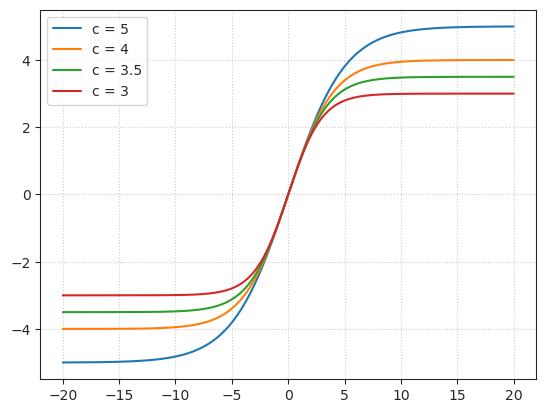

In [2]:
from vae.distributions import softclamp
x = torch.linspace(-20, 20, 1000)

for c in [5, 4, 3.5, 3]:
    plt.plot(to_np(x), to_np(softclamp(x, c)), label=f"c = {c}");
plt.legend()
plt.grid()
plt.show()

## Trainer

In [3]:
vae = VAE(ConfigVAE(
    n_latent_scales=2, n_groups_per_scale=20, n_latent_per_group=7,
    scale_init=False, residual_kl=True, ada_groups=True,
))
tr = TrainerVAE(
    model=vae,
    cfg=ConfigTrainVAE(
        lr=0.003, batch_size=500, epochs=2000, grad_clip=1000,
        lambda_anneal=True, lambda_init=1e-7, lambda_norm=1e-3,
        kl_beta=0.25, kl_anneal_cycles=1, kl_anneal_portion=0.3, 
        scheduler_kws={'T_max': 650.0, 'eta_min': 1e-05},
        optimizer='adamax_fast',
    ),
    device='cuda',
)
vae.cfg.total_latents()

210

In [4]:
vae.print()
vae.scales

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
|     VAE      |  17.0 Mil  |
|     ---      |    ---     |
|     stem     |   1.1 K    |
| pre_process  |   96.0 K   |
|  enc_tower   |  9.4 Mil   |
|     enc0     |   16.6 K   |
| enc_sampler  |  1.4 Mil   |
| dec_sampler  |  1.4 Mil   |
|    expand    |   71.0 K   |
|  dec_tower   |  4.5 Mil   |
| post_process |   40.0 K   |
|     out      |    578     |
+--------------+------------+

[8, 4]

In [5]:
len(vae.all_conv_layers), len(vae.all_log_norm)

(291, 228)

In [6]:
print({
    k: v for k, v in vars(vae.cfg).items() if
    '_dir' not in k and k != 'useful_cells'
})

{
    'n_kers': 4,
    'n_rots': 8,
    'ker_sz': 4,
    'input_sz': 19,
    'n_enc_cells': 2,
    'n_enc_nodes': 2,
    'n_dec_cells': 2,
    'n_dec_nodes': 1,
    'n_pre_cells': 3,
    'n_pre_blocks': 1,
    'n_post_cells': 3,
    'n_post_blocks': 1,
    'n_latent_scales': 2,
    'n_groups_per_scale': 20,
    'n_latent_per_group': 7,
    'spectral_norm': 0,
    'rot_equiv': False,
    'separable': False,
    'compress': True,
    'use_bn': False,
    'groups': [20, 10],
    'h_file': '/home/hadi/Documents/MTMST/data/MTLFP_tres25.h5',
    'h_pre': '/home/hadi/Documents/MTMST/data/simulation_dim-19_5e+04.h5',
    'seed': 0,
    'balanced_recon': True,
    'activation_fn': 'swish',
    'residual_kl': True,
    'scale_init': False,
    'ada_groups': True,
    'use_se': True
}

In [7]:
print(vars(tr.cfg))

{
    'lr': 0.003,
    'epochs': 2000,
    'batch_size': 500,
    'warmup_portion': 0.025,
    'optimizer': 'adamax_fast',
    'optimizer_kws': {'betas': (0.9, 0.999), 'weight_decay': 0.0001, 'eps': 1e-08},
    'scheduler_type': 'cosine',
    'scheduler_kws': {'T_max': 650.0, 'eta_min': 1e-05},
    'ema_rate': 0.999,
    'grad_clip': 1000,
    'chkpt_freq': 50,
    'eval_freq': 10,
    'log_freq': 20,
    'use_amp': False,
    'kl_beta': 0.25,
    'kl_beta_min': 0.0001,
    'kl_balancer': 'equal',
    'kl_anneal_cycles': 1,
    'kl_anneal_portion': 0.3,
    'kl_const_portion': 0.0001,
    'lambda_anneal': True,
    'lambda_init': 1e-07,
    'lambda_norm': 0.001,
    'spectral_reg': False
}

In [8]:
tr.optim

Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.003
    lr: 0.003
    weight_decay: 0.0001
)

## Review train options

In [9]:
print(f"{vae.cfg.name()}\n{tr.cfg.name()}")

k-32_z-7x[10,20]_enc(2x2)-dec(2x1)-pre(1x3)-post(1x3)
ep2000-b500-lr(0.003)_beta(0.25:1x0.3)_lamb(0.001)_gr(1000)

## Train

In [ ]:
comment = f"Clamp(4.0)+HigherLR+!!EPE-fixed!!_{tr.cfg.name()}"
tr.train(comment=comment)

gstep # 1.54e+05, nelbo: 11.085, grad: 98.0:  96%|▉| 1921/2000 [30:48:38<1:24:38

## Eval

In [11]:
%%time

val, loss = tr.validate(use_ema=False)
val_ema, loss_ema = tr.validate(use_ema=True)

CPU times: user 30.6 s, sys: 22.6 s, total: 53.2 s
Wall time: 1min 24s


In [12]:
loss_summary = {
    k: {
        'vae': np.round(v.mean(), 2),
        'ema': np.round(loss_ema[k].mean(), 2),
    } for k, v in loss.items()
}
print(f"{vae.cfg.name()}\n{tr.cfg.name()}\n{loss_summary}")

k-32_z-7x[10,20]_enc(2x2)-dec(2x1)-pre(1x3)-post(1x3)
ep2000-b500-lr(0.003)_beta(0.25:1x0.3)_lamb(0.001)_gr(1000)
{'epe': {'vae': 5.05, 'ema': 5.05}, 'kl': {'vae': 37.11, 'ema': 37.1}}

fig/sample (VAE)

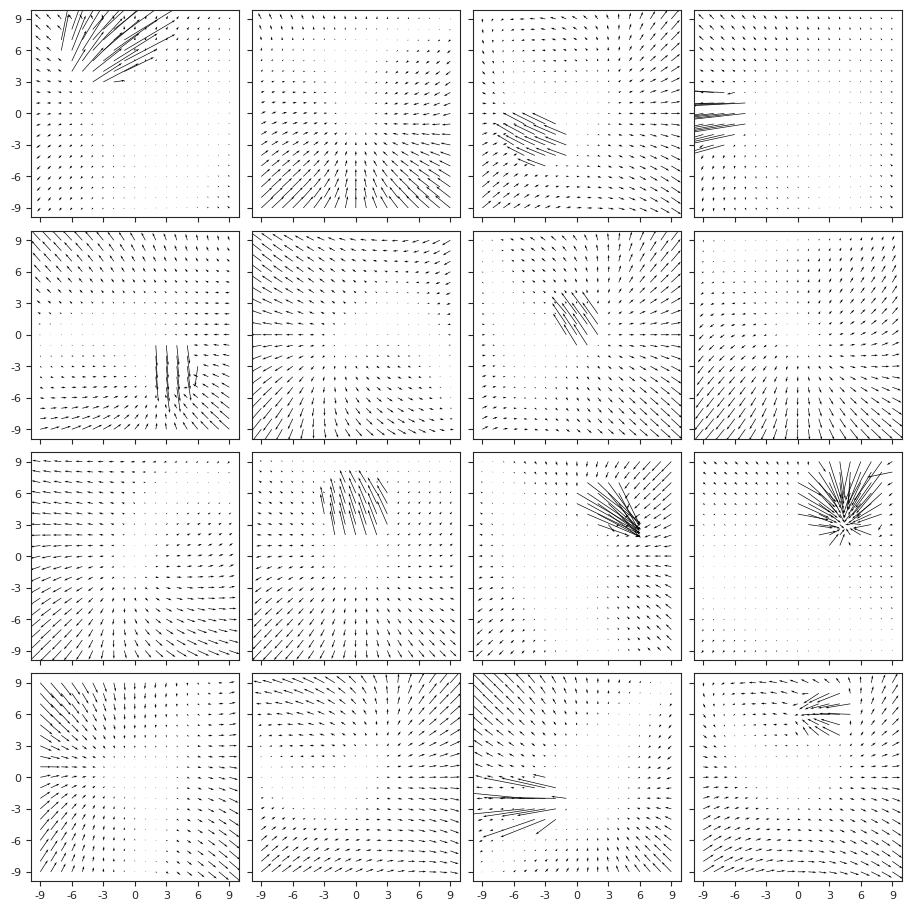

fig/sample (EMA)

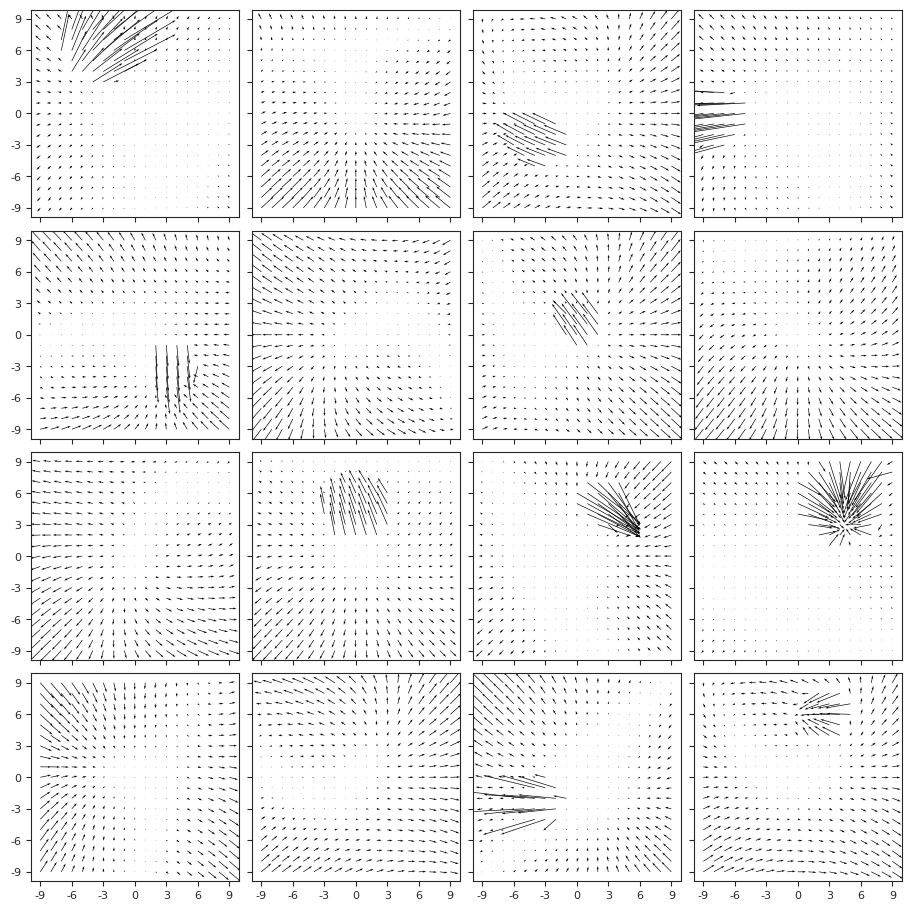

----------------------------------------------------------------------

fig/regression (VAE)

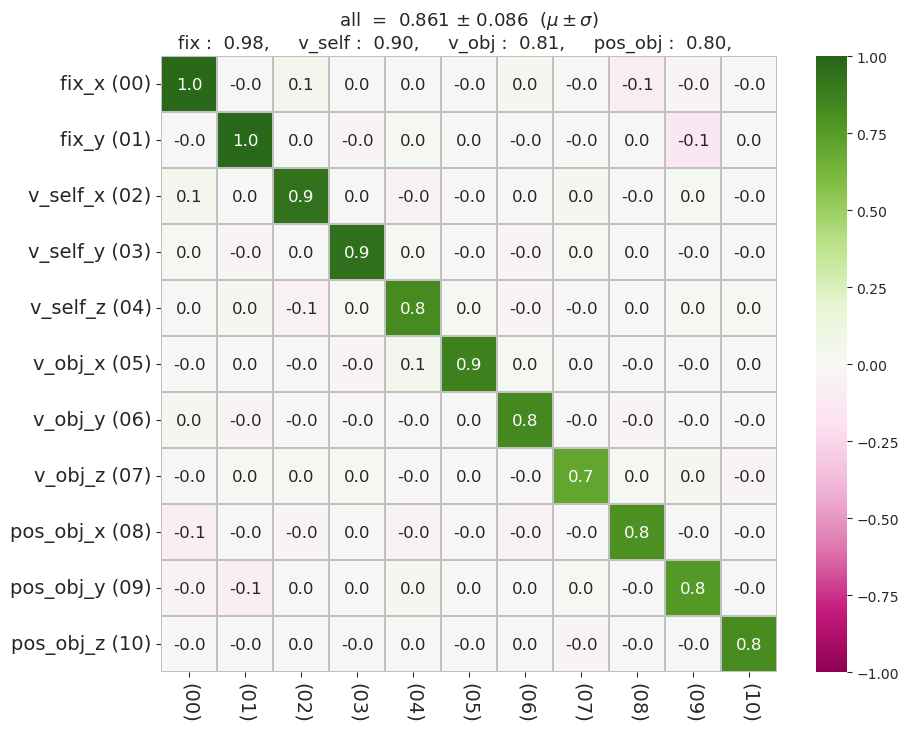

fig/regression (EMA)

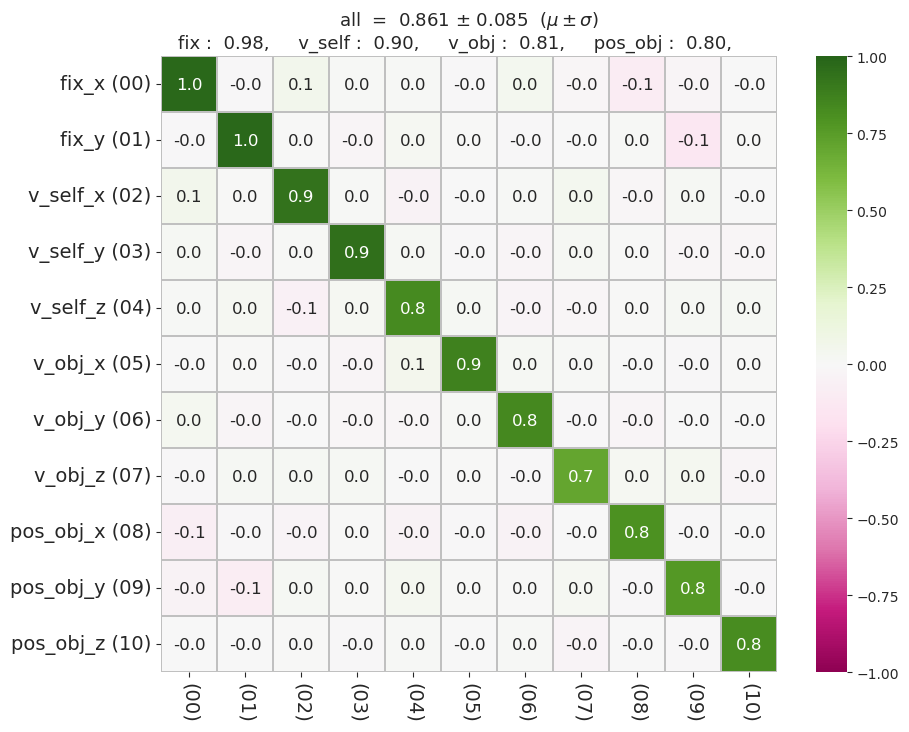

----------------------------------------------------------------------

fig/mutual_info (VAE)

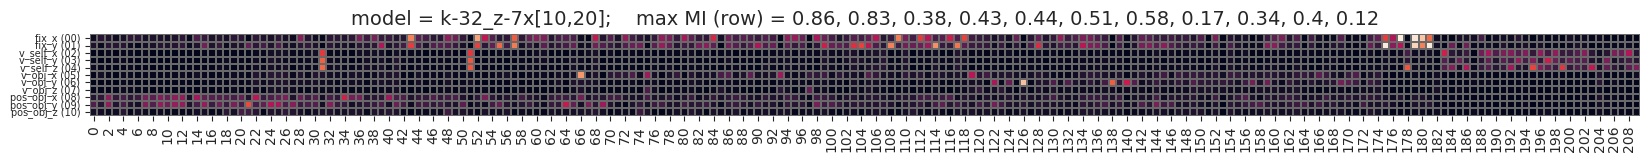

fig/mutual_info (EMA)

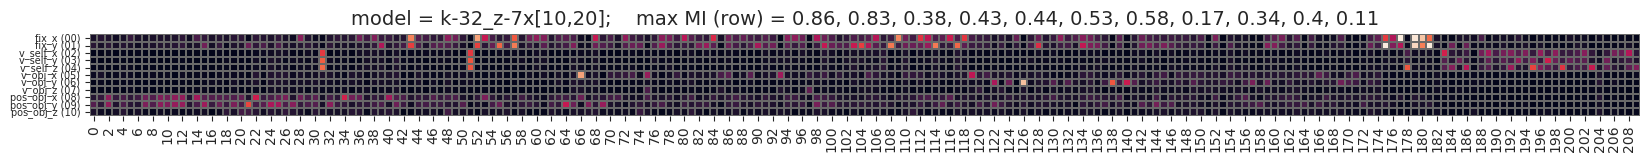

----------------------------------------------------------------------

In [13]:
for k, v in val.items():
    if 'fig' in k:
        print(f"{k} (VAE)")
        display(v)
        print(f"{k} (EMA)")
        display(val_ema[k])
        print('-' * 70)

## DCI

In [24]:
val_ema['regr/r2'].mean()

0.749128451260054

In [25]:
x = val_ema['z_vld'].copy()
y = val_ema['g_vld'].copy()
x_tst = val_ema['z_tst'].copy()
y_tst = val_ema['g_tst'].copy()

mu, sd = x.mean(), x.std()
x = (x - mu) / sd
x_tst = (x_tst - mu) / sd

In [40]:
lasso = sk_linear.Lasso(3e-3).fit(x, y)
r2_lasso = sk_metric.r2_score(y_tst, lasso.predict(x_tst))

In [41]:
r2_lasso

0.7123792166063737

In [42]:
from analysis.linear import compute_dci

In [43]:
w = np.abs(lasso.coef_)
w *= x.std(0).reshape(1, -1)
w /= y.std(0).reshape(-1, 1)
d, c = compute_dci(w)
d, c

(0.6261653, 0.49691677)

In [45]:
lr = sk_linear.LinearRegression().fit(x, y)
r2_lr = sk_metric.r2_score(y_tst, lr.predict(x_tst))
r2_lr

0.749128451260054

In [46]:
w = np.abs(lr.coef_)
w *= x.std(0).reshape(1, -1)
w /= y.std(0).reshape(-1, 1)
d, c = compute_dci(w)
d, c

(0.2029955, 0.23375988)

In [64]:
r2_one_by_one = []
perm_score = np.zeros((11, 210))
for i in tqdm(range(11)):
    lr = sk_linear.LinearRegression().fit(x, y[:, i])
    r2_lr = sk_metric.r2_score(y_tst[:, i], lr.predict(x_tst))
    r2_one_by_one.append(r2_lr)
    perm = sk_inspect.permutation_importance(lr, x_tst, y_tst[:, i], n_repeats=10, random_state=0)
    perm_score[i] = perm['importances_mean']

  0%|          | 0/11 [00:00<?, ?it/s]

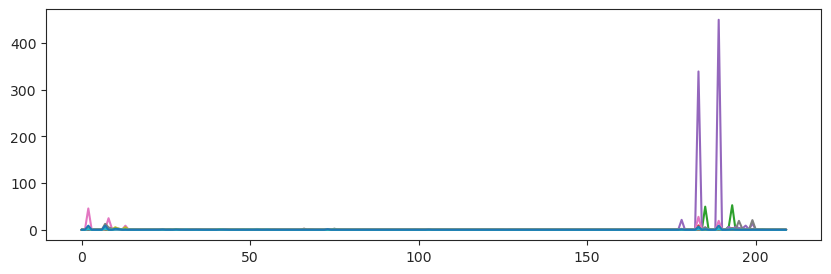

In [88]:
fig, ax = create_figure(1, 1, (10, 3))
plt.plot(perm_score.T);

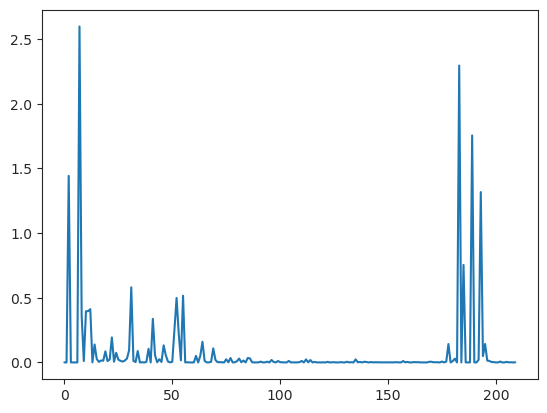

In [89]:
plt.plot(perm_score[9])

In [91]:
d, c = compute_dci(np.abs(perm_score))
d, c

(0.6669626817536156, 0.5415457920251826)

In [93]:
d, c = compute_dci(np.maximum(perm_score, 0))
d, c

(0.6669870109847706, 0.541595143782844)

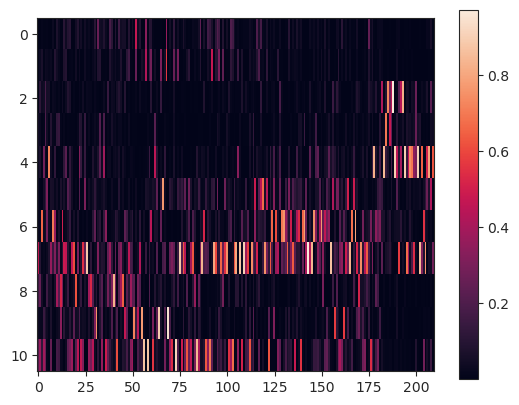

In [106]:
plt.imshow(np.abs(perm_score) / np.abs(perm_score).sum(0, keepdims=True), aspect=17)
plt.colorbar();

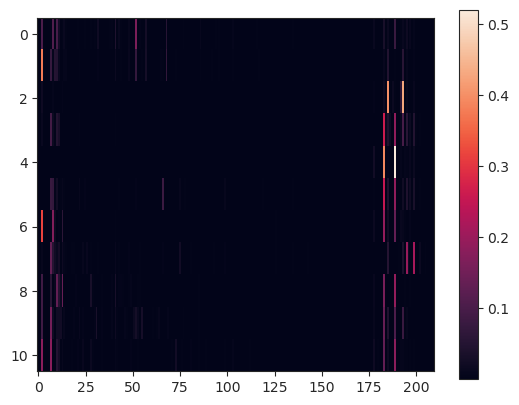

In [107]:
plt.imshow(np.abs(perm_score) / np.abs(perm_score).sum(1, keepdims=True), aspect=17)
plt.colorbar();

In [15]:
from sklearn import linear_model as sk_linear

In [16]:
list(val_ema)

['x_sample',
 'z_sample',
 'z_vld',
 'z_tst',
 'g_vld',
 'g_tst',
 'regr/mi',
 'regr/r',
 'regr/lr',
 'fig/sample',
 'fig/regression',
 'fig/mutual_info']

In [111]:
lr = sk_linear.LinearRegression().fit(
    val_ema['z_vld'], val_ema['g_vld'])
r2 =  r2_score(
    y_true=val_ema['g_tst'],
    y_pred=lr.predict(val_ema['z_tst']),
    multioutput='raw_values',
)
r2, r2.mean()

(array([0.96606131, 0.96345844, 0.89730383, 0.9276483 , 0.8661773 ,
        0.6994048 , 0.68869248, 0.42437212, 0.59958057, 0.53706926,
        0.65859808]),
 0.7480333166219819)

In [112]:
lr_zscored = sk_linear.LinearRegression().fit(
    sp_stats.zscore(val_ema['z_vld']), sp_stats.zscore(val_ema['g_vld']))
r2_zscored =  r2_score(
    y_true=sp_stats.zscore(val_ema['g_tst']),
    y_pred=lr_zscored.predict(sp_stats.zscore(val_ema['z_tst'])),
    multioutput='raw_values',
)
r2_zscored, r2_zscored.mean()

(array([0.96598225, 0.96300722, 0.89173994, 0.92703549, 0.85417953,
        0.70017856, 0.6889566 , 0.42107905, 0.59837419, 0.53696462,
        0.65388017]),
 0.7455797833226978)

In [115]:
w_zscored = np.abs(lr_zscored.coef_)
rho_zscored = w_zscored.sum(0) / w_zscored.sum()

sigma_z = val_ema['z_vld'].std(0)
sigma_g = val_ema['g_vld'].std(0)
w = np.abs(lr.coef_)
w *= sigma_z.reshape(1, -1)
w /= sigma_g.reshape(-1, 1)
rho = w.sum(0) / w.sum()

In [117]:
def do(w):
    p_disentang = w / w.sum(0, keepdims=True)
    p_complete = w / w.sum(1, keepdims=True)

    disentang_i = 1 - sp_stats.entropy(p_disentang, axis=0) / np.log(w.shape[0])
    complete_mu = 1 - sp_stats.entropy(p_complete, axis=1) / np.log(w.shape[1])

    disentang = (disentang_i * rho).sum()
    complete = complete_mu.mean()

    print(disentang, complete)

In [120]:
do(w)

0.21788052 0.21617304

In [121]:
do(w_zscored)

0.21769267 0.21608505

<AxesSubplot:ylabel='Count'>

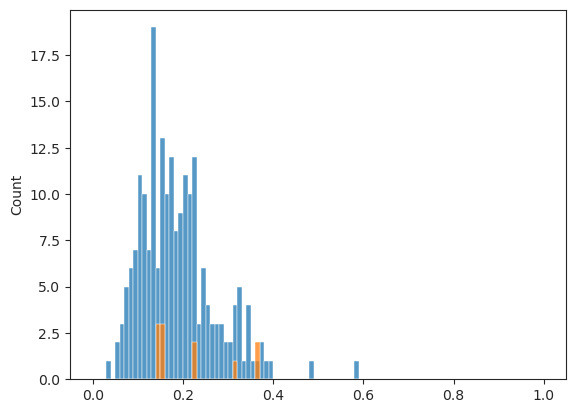

In [84]:
sns.histplot(disentang_i, bins=np.linspace(0, 1, 101), color='C0', label=r'$D_i$')
sns.histplot(complete_mu, bins=np.linspace(0, 1, 101), color='C1', label=r'$D_i$')

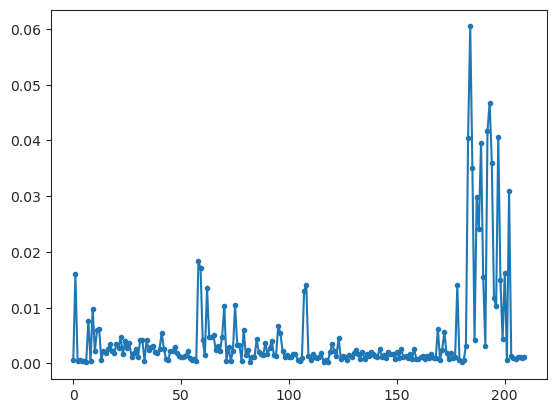

In [85]:
rho = w.sum(0) / w.sum()
plt.plot(rho, marker='.')
plt.show()

In [88]:
disentang = (disentang_i * rho).sum()
complete = complete_mu.mean()

disentang, complete

(0.21788054225119038, 0.216173062261763)

In [91]:
lasso = sk_linear.MultiTaskLassoCV(
    eps=1e-5,
    n_alphas=200,
).fit(val_ema['z_vld'], val_ema['g_vld'])

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7021244764328003, tolerance: 1.3827462196350098
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.495604395866394, tolerance: 1.3827462196350098
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.103717565536499, tolerance: 1.3827462196350098
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklea

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 269.69793701171875, tolerance: 1.3827462196350098
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 293.702880859375, tolerance: 1.3827462196350098
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 317.4812316894531, tolerance: 1.3827462196350098
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklear

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.668560028076172, tolerance: 1.394180178642273
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.964919090270996, tolerance: 1.394180178642273
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.502042770385742, tolerance: 1.394180178642273
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklear

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 356.50103759765625, tolerance: 1.394180178642273
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 373.3648986816406, tolerance: 1.394180178642273
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 389.7500915527344, tolerance: 1.394180178642273
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.244288444519043, tolerance: 1.3907557725906372
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.472373962402344, tolerance: 1.3907557725906372
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.409197807312012, tolerance: 1.3907557725906372
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/hadi/anaconda3/lib/python3.8/site-packages/skle

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 287.20782470703125, tolerance: 1.3907557725906372
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 304.5367736816406, tolerance: 1.3907557725906372
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 321.5251159667969, tolerance: 1.3907557725906372
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklea

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.100500583648682, tolerance: 1.3807060718536377
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.810996055603027, tolerance: 1.3807060718536377
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.786028861999512, tolerance: 1.3807060718536377
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklea

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 309.5011291503906, tolerance: 1.3807060718536377
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 330.97930908203125, tolerance: 1.3807060718536377
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 351.6184997558594, tolerance: 1.3807060718536377
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklea

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.436305999755859, tolerance: 1.3974210023880005
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.136590003967285, tolerance: 1.3974210023880005
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.153860092163086, tolerance: 1.3974210023880005
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklea

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 191.78860473632812, tolerance: 1.3974210023880005
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 209.8300018310547, tolerance: 1.3974210023880005
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 228.07286071777344, tolerance: 1.3974210023880005
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/hadi/anaconda3/lib/python3.8/site-packages/skle

In [93]:
lasso.alpha_

0.0007215736665858717

In [96]:
lasso.score(val_ema['z_vld'], val_ema['g_vld'])

0.7637221020071737

In [98]:
lasso = sk_linear.Lasso(
    alpha=0.0007215736665858717, max_iter=1e7,
).fit(val_ema['z_vld'], val_ema['g_vld'])

In [104]:
r2 =  r2_score(
    y_true=val_ema['g_tst'],
    y_pred=lasso.predict(val_ema['z_tst']),
    multioutput='raw_values',
)
r2, r2.mean()

(array([0.96627827, 0.96330325, 0.89514795, 0.92649064, 0.8640723 ,
        0.70129863, 0.68712573, 0.42420122, 0.59915968, 0.53896282,
        0.6487912 ]),
 0.7468028799060433)

In [105]:
sigma_z = val_ema['z_vld'].std(0)
sigma_g = val_ema['g_vld'].std(0)

w = np.abs(lr.coef_)
w *= sigma_z.reshape(1, -1)
w /= sigma_g.reshape(-1, 1)
w.shape

(11, 210)

In [106]:
p_disentang = w / w.sum(0, keepdims=True)
p_complete = w / w.sum(1, keepdims=True)

disentang_i = 1 - sp_stats.entropy(p_disentang, axis=0) / np.log(w.shape[0])
complete_mu = 1 - sp_stats.entropy(p_complete, axis=1) / np.log(w.shape[1])

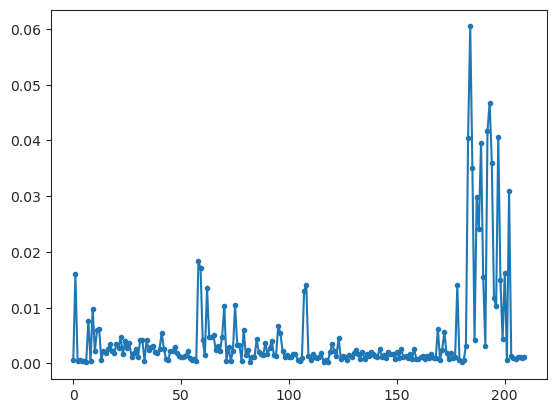

In [107]:
rho = w.sum(0) / w.sum()
plt.plot(rho, marker='.')
plt.show()

In [108]:
disentang = (disentang_i * rho).sum()
complete = complete_mu.mean()

disentang, complete

(0.21788052, 0.21617304)

In [265]:
%%time

output = regress(
    z=val_ema['z_vld'],
    g=val_ema['g_vld'],
    z_tst=val_ema['z_tst'],
    g_tst=val_ema['g_tst'],
)

CPU times: user 11.2 s, sys: 5.46 s, total: 16.7 s
Wall time: 20.4 s


In [266]:
list(output)

['mi', 'mi_normalized', 'mig', 'r', 'r2', 'd', 'c']

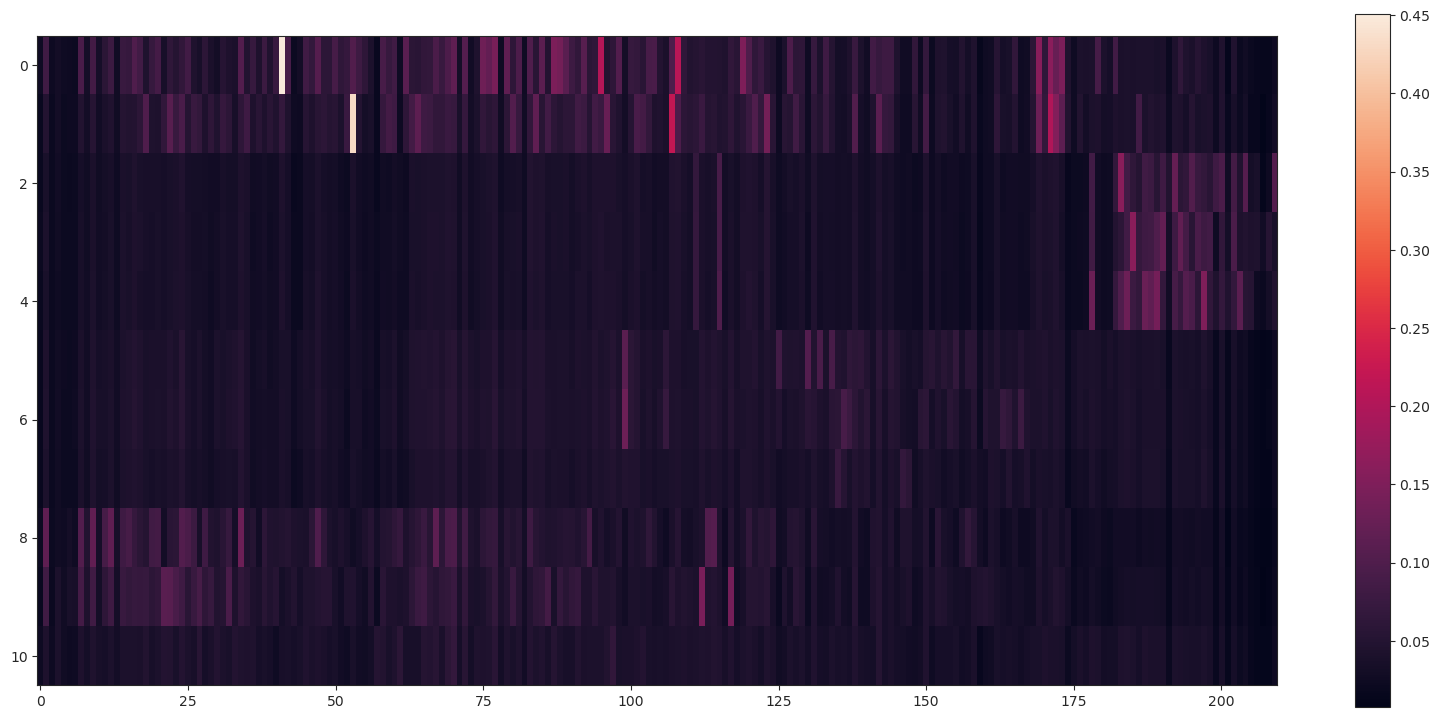

In [267]:
fig, ax = create_figure(1, 1, (20, 9))
plt.imshow(output['mi_normalized'], aspect=10)
plt.colorbar()

In [268]:
output['mig']

0.05549623431206208

In [255]:
inds_sorted = np.argsort(output['mi_normalized'])[:, ::-1]

In [257]:
inds_sorted[0, :2]

array([ 41, 108])

In [258]:
output['mi_normalized'][0, 41] - output['mi_normalized'][0, 108]

0.2405144469446142

In [259]:
output['mi_normalized'][0, 41], output['mi_normalized'][0, 108]

(0.45073208557941163, 0.21021763863479742)

In [263]:
mig(output['mi_normalized']).mean()

0.05549623431206208

In [306]:
%%time

output = regress(val['z_vld'], val['g_vld'], val['z_tst'], val['g_tst'])

CPU times: user 4.33 s, sys: 11.1 s, total: 15.5 s
Wall time: 19.3 s


In [310]:
output['mig']

0.06438530708701035

In [307]:
np.max(output['mi_normalized'], axis=1).mean()

0.1989187654111317

In [308]:
np.max(output['mi'], axis=1).mean()

0.5807873774234878

In [311]:
list(output)

['mi', 'mi_normalized', 'mig', 'r', 'r2', 'd', 'c']

In [313]:
output['d']

0.21561372

### Below was beta = 0.1, with non-separable sampler

In [9]:
%%time

val, loss = tr.validate(use_ema=False)
val_ema, loss_ema = tr.validate(use_ema=True)

CPU times: user 29.6 s, sys: 8.35 s, total: 37.9 s
Wall time: 41.3 s


In [10]:
loss_summary = {
    k: {
        'vae': np.round(v.mean(), 2),
        'ema': np.round(loss_ema[k].mean(), 2),
    } for k, v in loss.items()
}
print(loss_summary)

{'epe': {'vae': 1.58, 'ema': 1.58}, 'kl': {'vae': 65.91, 'ema': 65.37}}

fig/sample (VAE)

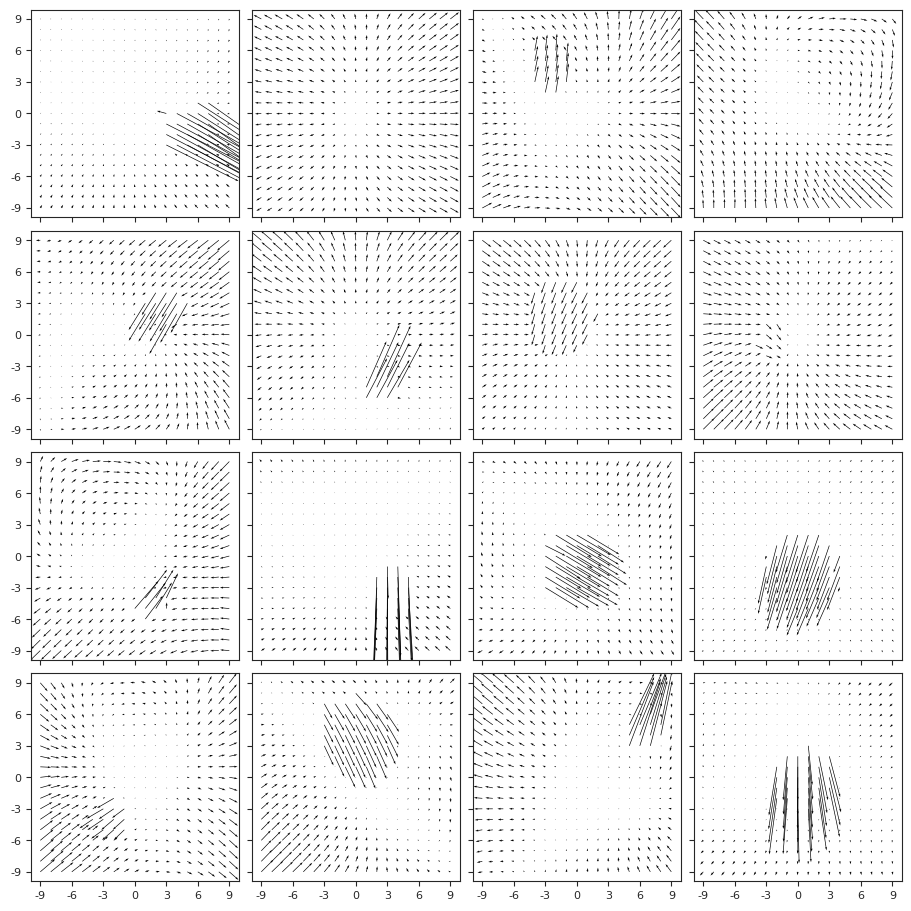

fig/sample (EMA)

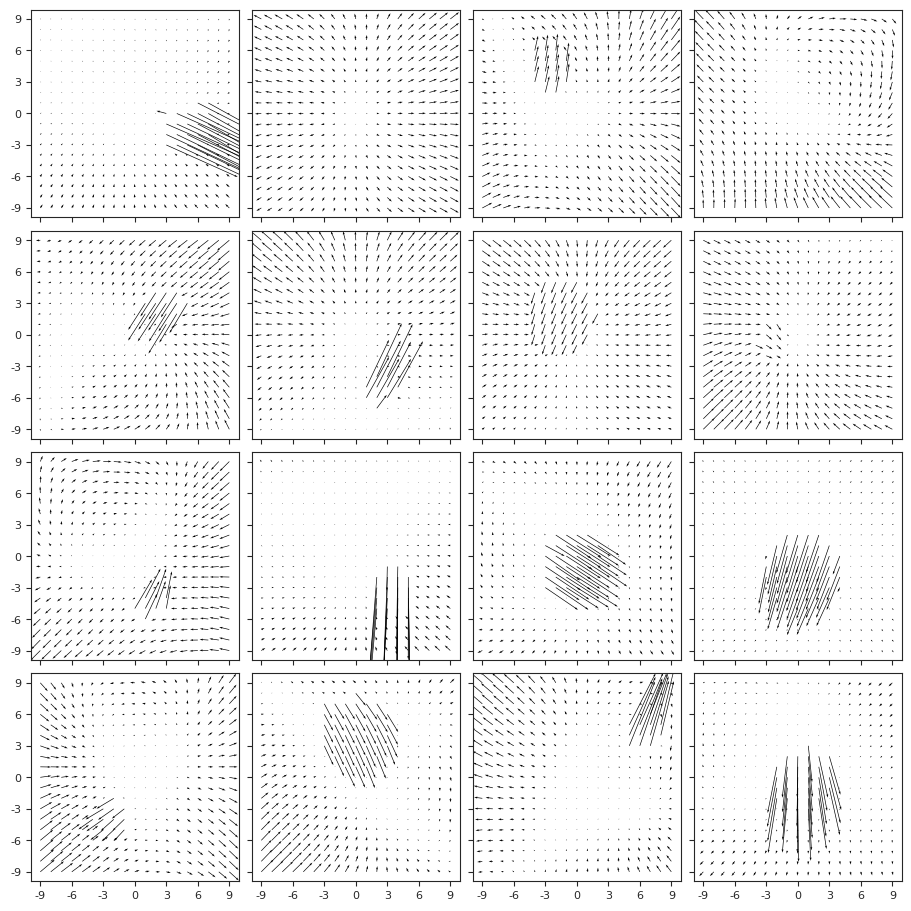

----------------------------------------------------------------------

fig/regression (VAE)

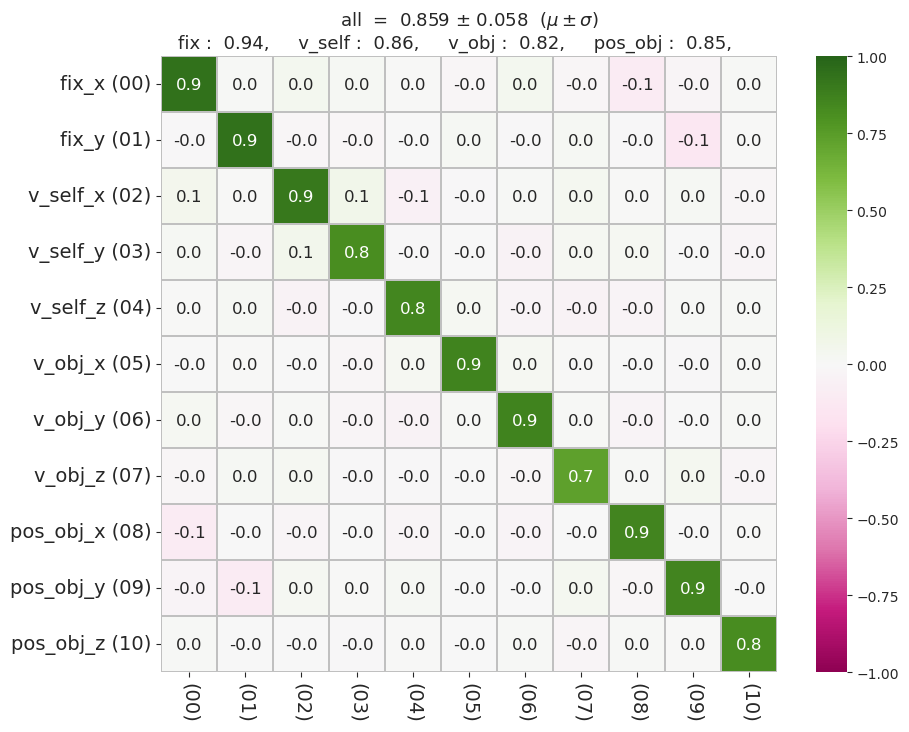

fig/regression (EMA)

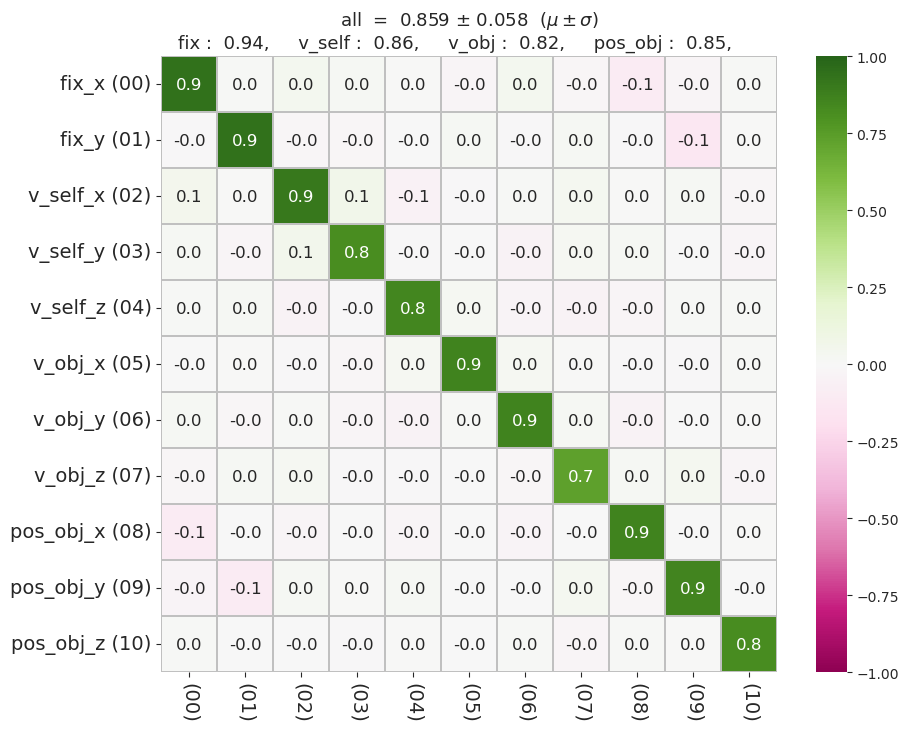

----------------------------------------------------------------------

fig/mutual_info (VAE)

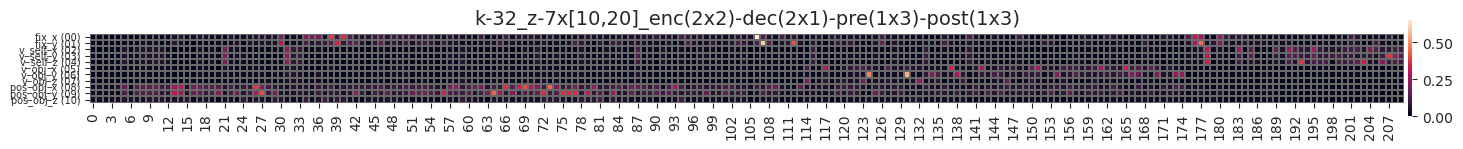

fig/mutual_info (EMA)

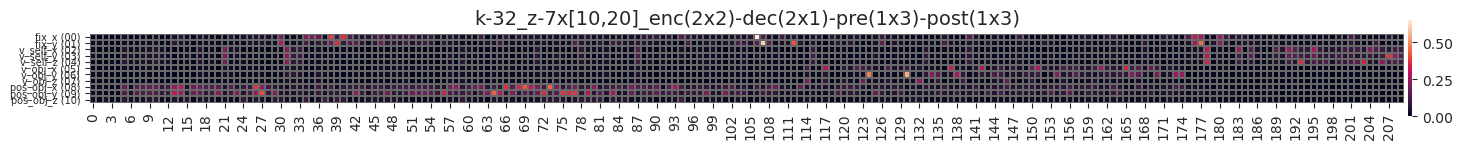

----------------------------------------------------------------------

In [11]:
for k, v in val.items():
    if 'fig' in k:
        print(f"{k} (VAE)")
        display(v)
        print(f"{k} (EMA)")
        display(val_ema[k])
        print('-' * 70)

In [12]:
from model.vae2d import *

In [108]:
norms = collections.defaultdict(list)
# norms['stem'] = list(to_np(vae.stem.lognorm.exp()))
for cell in vae.enc_tower:
    for m in cell.modules():
        if hasattr(m, 'lognorm'):
            norms[f"{type(cell).__name__}_enc"].extend(
                list(to_np(m.lognorm.exp())))
for cell in vae.dec_tower:
    for m in cell.modules():
        if hasattr(m, 'lognorm'):
            norms[f"{type(cell).__name__}_dec"].extend(
                list(to_np(m.lognorm.exp())))
for cell in vae.enc_sampler:
    for m in cell.modules():
        if hasattr(m, 'lognorm'):
            norms['enc_sampler'].extend(
                list(to_np(m.lognorm.exp())))
for cell in vae.dec_sampler:
    for m in cell.modules():
        if hasattr(m, 'lognorm'):
            norms['dec_sampler'].extend(
                list(to_np(m.lognorm.exp())))
for cell in vae.expand:
    for m in cell.modules():
        if hasattr(m, 'lognorm'):
            norms['expand'].extend(
                list(to_np(m.lognorm.exp())))
for cell in vae.pre_process:
    for m in cell.modules():
        if hasattr(m, 'lognorm'):
            norms[f"{type(cell).__name__}_pre"].extend(
                list(to_np(m.lognorm.exp())))
for cell in vae.post_process:
    for m in cell.modules():
        if hasattr(m, 'lognorm'):
            norms[f"{type(cell).__name__}_post"].extend(
                list(to_np(m.lognorm.exp())))
norms = dict(sorted(norms.items()))

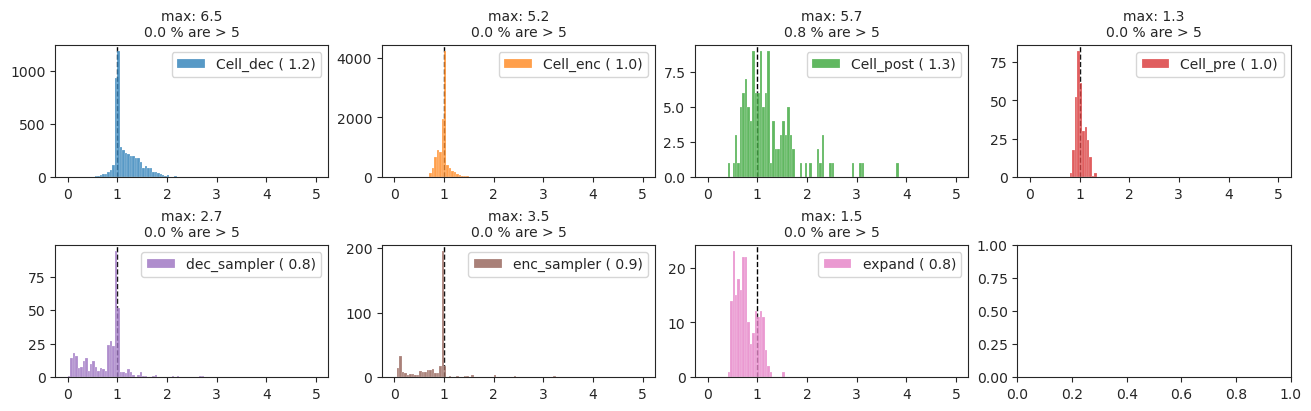

In [109]:
fig, axes = create_figure(2, 4, (13, 4), constrained_layout=True)
for i, (k, v) in enumerate(norms.items()):
    ax = axes.flat[i]
    ax.axvline(1, color='k', ls='--', lw=1.0, zorder=0)
    sns.histplot(v, color=f"C{i}", bins=np.linspace(0, 5, 101), label=f"{k} ({np.mean(v): 0.1f})", ax=ax)
    title = f"max: {np.max(v):0.1f}\n{100 * (np.array(v) > 5).sum() / len(v):0.1f} % are > 5"
    ax.set_title(title, fontsize=10)
    ax.set_ylabel('')
    ax.legend()
plt.show()

In [111]:
w = vae.enc_sampler[25].conv.weight
w.size(), w.numel()

(torch.Size([14, 64, 8, 8]), 57344)

In [113]:
w = vae.dec_sampler[25].conv.weight
w.size(), w.numel()

(torch.Size([14, 64, 8, 8]), 57344)

In [31]:
depthwise = nn.Conv2d(64, 64, kernel_size=8, groups=64)
pointwise = nn.Conv2d(64, 14, kernel_size=1)

depthwise.weight.size(), pointwise.weight.size()

(torch.Size([64, 1, 8, 8]), torch.Size([14, 64, 1, 1]))

In [32]:
depthwise.weight.numel() + pointwise.weight.numel()

4992

In [81]:
sampler = Sampler(64, 7, 8, 'none', True, False, 0.7)
print_num_params(sampler.conv)

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|    Conv2D   |   57.4 K   |
|     ---     |    ---     |
+-------------+------------+

In [82]:
sampler.conv.lognorm

Parameter containing:
tensor([-0.3567, -0.3567, -0.3567, -0.3567, -0.3567, -0.3567, -0.3567, -0.3567,
        -0.3567, -0.3567, -0.3567, -0.3567, -0.3567, -0.3567],
       requires_grad=True)

In [83]:
sampler.conv.apply_norm

False

In [84]:
sampler = Sampler(64, 7, 8, 'none', True, True, 0.7)
print_num_params(sampler.conv)

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|  Sequential |   5.2 K    |
|     ---     |    ---     |
|      0      |   4.2 K    |
|      1      |    924     |
+-------------+------------+

In [85]:
x = torch.randn(13, 64, 8, 8)
y = sampler(x)
y.size()

torch.Size([13, 14, 1, 1])

In [86]:
m = sampler.conv[0]
m.apply_norm, m.lognorm

(True,
 Parameter containing:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        requires_grad=True))

In [87]:
m = sampler.conv[1]
m.apply_norm, m.lognorm

(False,
 Parameter containing:
 tensor([-0.3567, -0.3567, -0.3567, -0.3567, -0.3567, -0.3567, -0.3567, -0.3567,
         -0.3567, -0.3567, -0.3567, -0.3567, -0.3567, -0.3567],
        requires_grad=True))

In [127]:
for m in vae.expand:
    print(m.lognorm.exp().mean().item(), m.lognorm.exp().data)

1.0394988059997559 tensor([1.1359, 0.8827, 0.9320, 1.1145, 1.0858, 1.1325, 0.9930],
       device='cuda:0')

0.776739239692688 tensor([0.7671, 0.7769, 0.7555, 0.8266, 0.6549, 0.6813, 0.9748],
       device='cuda:0')

0.7659563422203064 tensor([0.7676, 0.8065, 0.8216, 0.6980, 0.7331, 0.7738, 0.7611],
       device='cuda:0')

0.8277194499969482 tensor([0.7800, 0.8454, 0.7054, 0.7839, 0.9009, 0.9988, 0.7797],
       device='cuda:0')

0.7851305603981018 tensor([0.9030, 0.8881, 0.7078, 0.8149, 0.7304, 0.6679, 0.7838],
       device='cuda:0')

0.845258355140686 tensor([1.0537, 0.8565, 0.8290, 0.7066, 0.8254, 0.6476, 0.9979],
       device='cuda:0')

0.7212343811988831 tensor([0.6993, 0.6741, 0.7271, 0.7030, 0.7997, 0.6870, 0.7584],
       device='cuda:0')

0.9246117472648621 tensor([0.9886, 1.1245, 0.9456, 0.7902, 0.7726, 1.0683, 0.7825],
       device='cuda:0')

0.8610206842422485 tensor([0.9692, 0.8075, 0.7024, 0.6099, 1.1648, 0.7341, 1.0394],
       device='cuda:0')

0.7860981225967407 tensor([0.7915, 0.7836, 0.5939, 0.7433, 0.8136, 1.0622, 0.7145],
       device='cuda:0')

0.63181471824646 tensor([0.4918, 1.1914, 0.5295, 0.4855, 0.7545, 0.5269, 0.4430],
       device='cuda:0')

0.48387444019317627 tensor([0.4788, 0.4884, 0.4757, 0.4870, 0.4902, 0.4850, 0.4820],
       device='cuda:0')

0.5774666666984558 tensor([0.5998, 0.5937, 0.4901, 0.5859, 0.5989, 0.5887, 0.5851],
       device='cuda:0')

0.7014853954315186 tensor([0.6078, 0.6033, 0.9001, 0.6260, 0.9141, 0.6280, 0.6311],
       device='cuda:0')

0.5021299719810486 tensor([0.5138, 0.5045, 0.5017, 0.4950, 0.5079, 0.4954, 0.4965],
       device='cuda:0')

0.5171862244606018 tensor([0.5297, 0.5241, 0.5091, 0.5162, 0.5064, 0.5159, 0.5189],
       device='cuda:0')

0.5114686489105225 tensor([0.5156, 0.5084, 0.5104, 0.4998, 0.5289, 0.5054, 0.5117],
       device='cuda:0')

1.1360946893692017 tensor([1.1966, 1.2679, 1.2262, 1.0317, 1.1036, 1.1605, 0.9662],
       device='cuda:0')

0.7974134683609009 tensor([0.8449, 0.6560, 0.6580, 0.6348, 0.6221, 1.0171, 1.1491],
       device='cuda:0')

0.6499118804931641 tensor([0.6916, 0.5903, 0.5928, 0.8540, 0.5841, 0.6392, 0.5974],
       device='cuda:0')

0.6807239055633545 tensor([0.6592, 0.6518, 0.6305, 0.6746, 0.8517, 0.6325, 0.6647],
       device='cuda:0')

0.8899689316749573 tensor([1.5225, 0.7424, 0.7468, 0.9685, 0.7416, 0.7747, 0.7333],
       device='cuda:0')

0.7092200517654419 tensor([0.7156, 0.7171, 0.5721, 0.6212, 0.6463, 0.6359, 1.0564],
       device='cuda:0')

0.7113000154495239 tensor([0.7312, 0.5784, 0.7124, 0.8897, 0.6215, 0.7207, 0.7251],
       device='cuda:0')

0.6579544544219971 tensor([0.6099, 0.5594, 0.5364, 0.6121, 0.9532, 0.5695, 0.7652],
       device='cuda:0')

1.0276095867156982 tensor([0.9861, 1.0150, 1.0768, 1.0487, 1.0234, 0.9132, 1.1300],
       device='cuda:0')

1.088754653930664 tensor([0.9463, 1.0664, 1.1135, 1.1378, 1.2146, 1.0831, 1.0596],
       device='cuda:0')

1.039860725402832 tensor([1.1695, 1.0300, 1.0452, 1.1240, 0.7807, 1.0306, 1.0991],
       device='cuda:0')

1.0486493110656738 tensor([0.9932, 1.0985, 0.9952, 1.0095, 1.0056, 1.0997, 1.1388],
       device='cuda:0')

0.6334809064865112 tensor([0.5220, 0.5112, 0.6801, 0.7727, 0.7376, 0.5226, 0.6882],
       device='cuda:0')

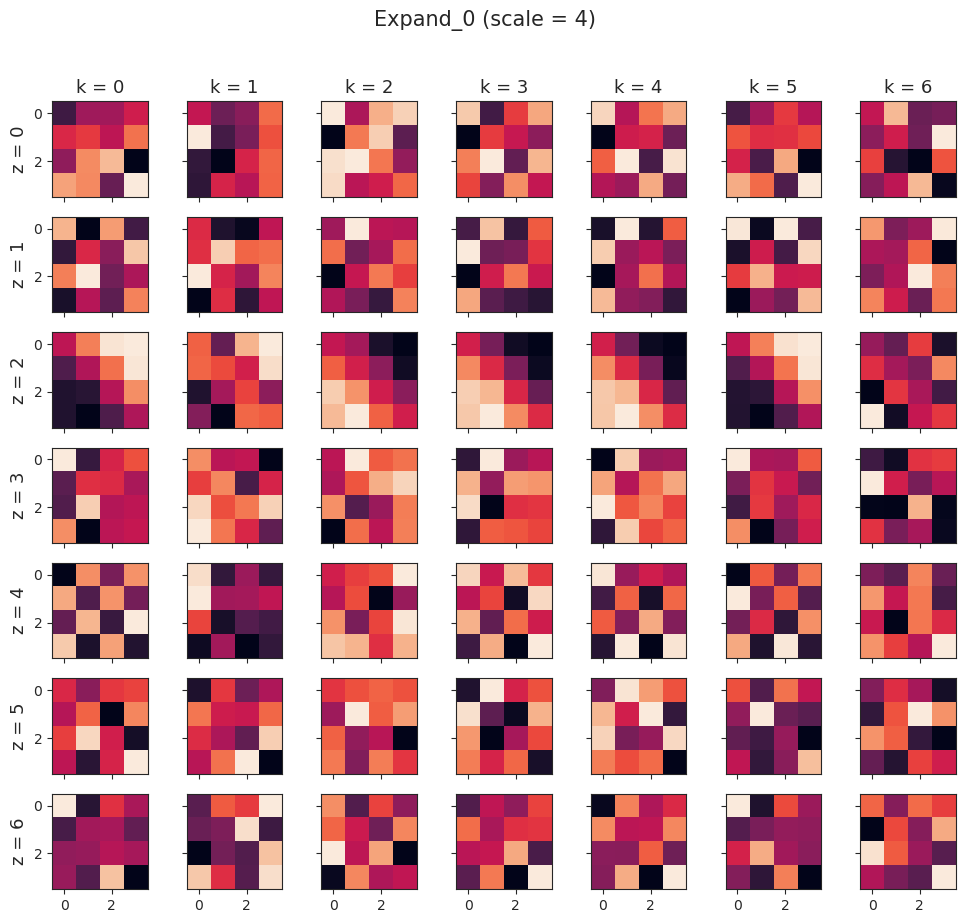

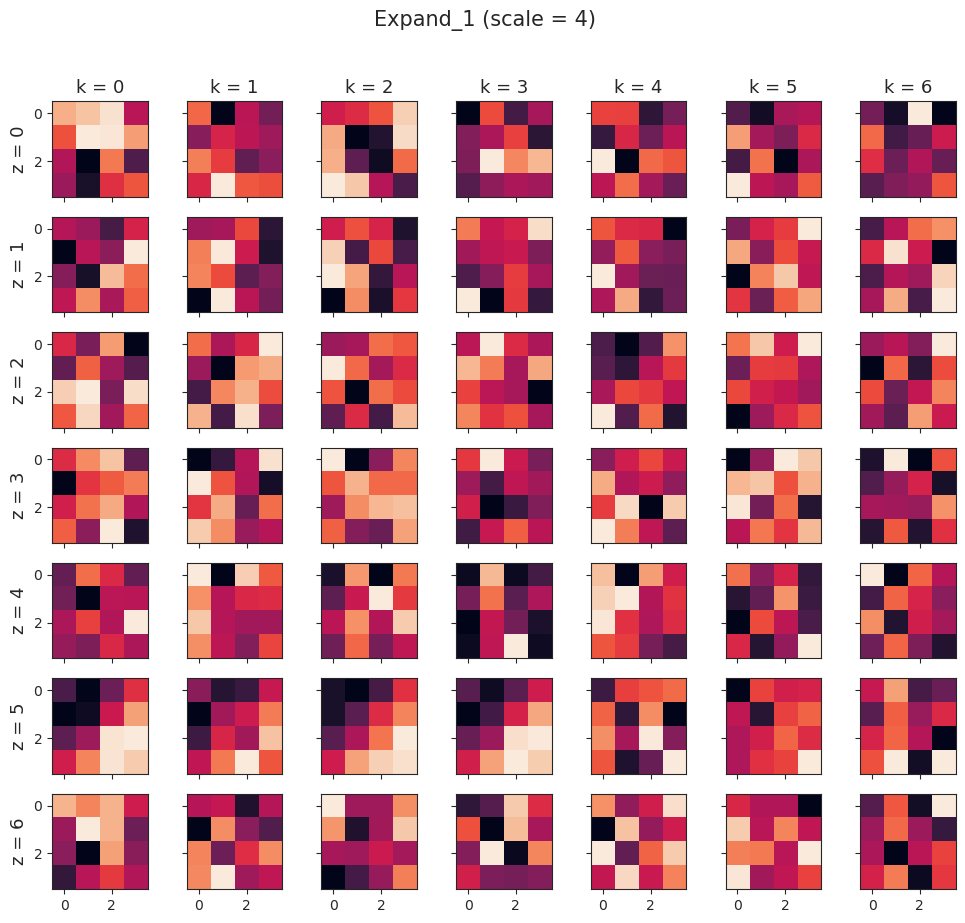

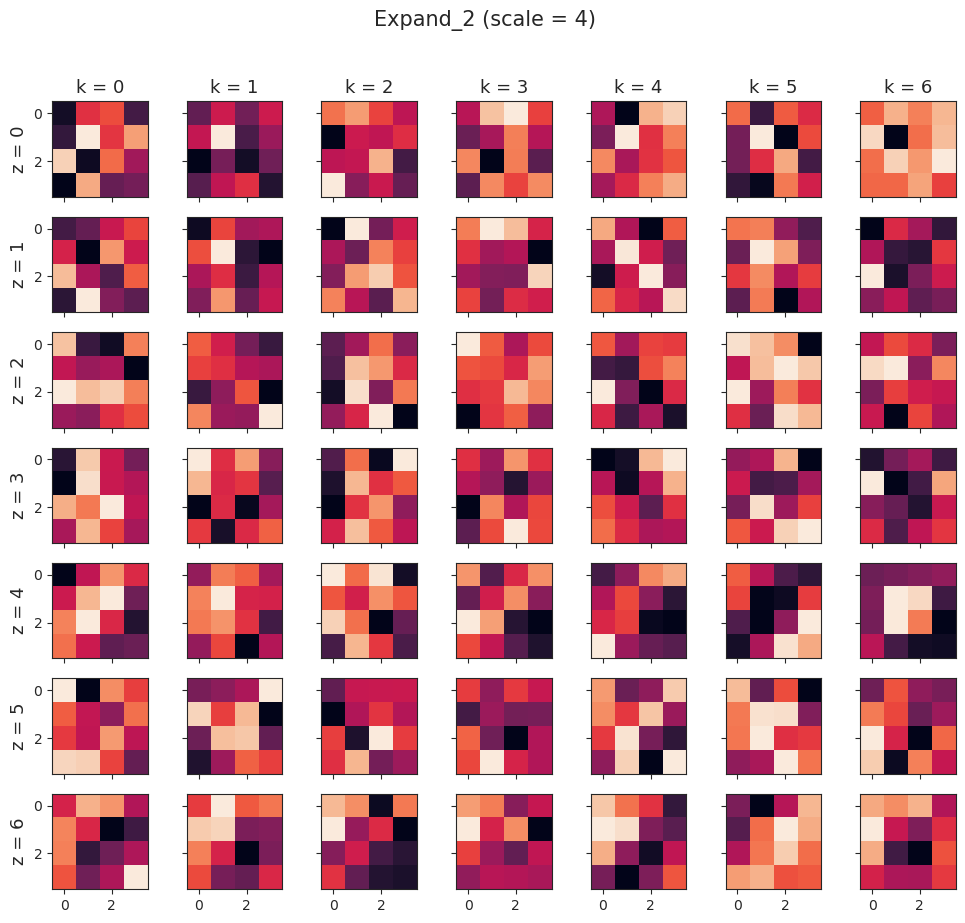

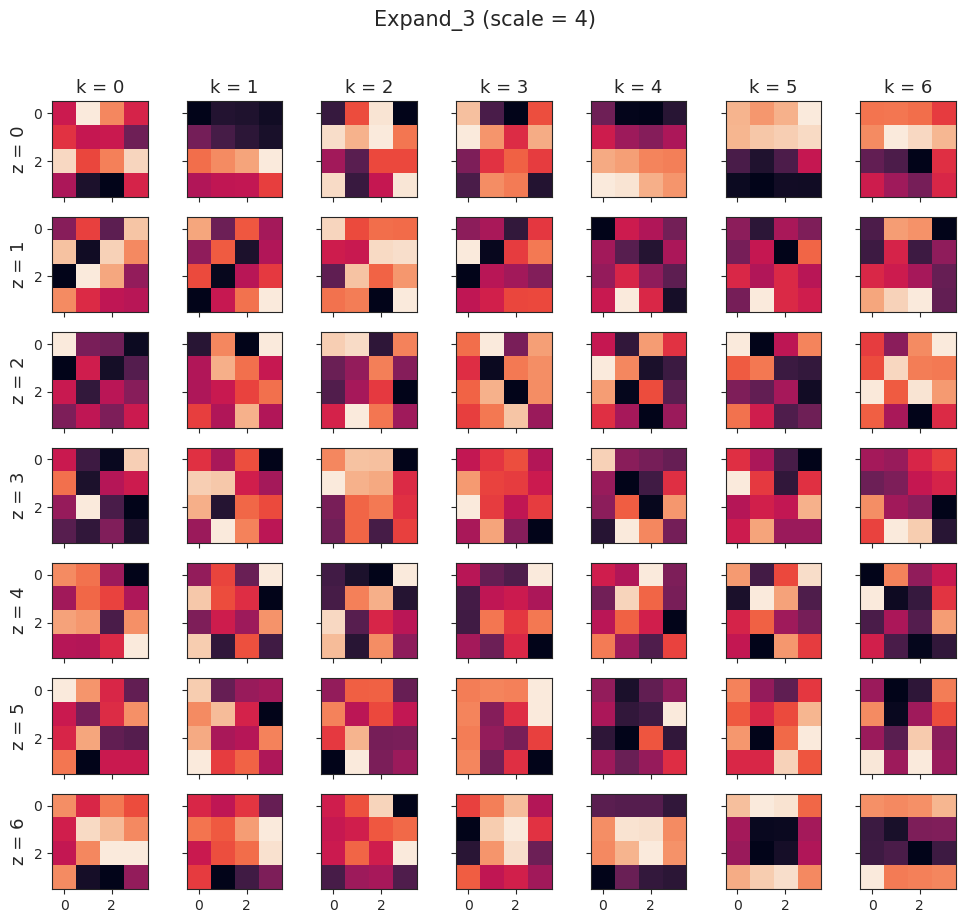

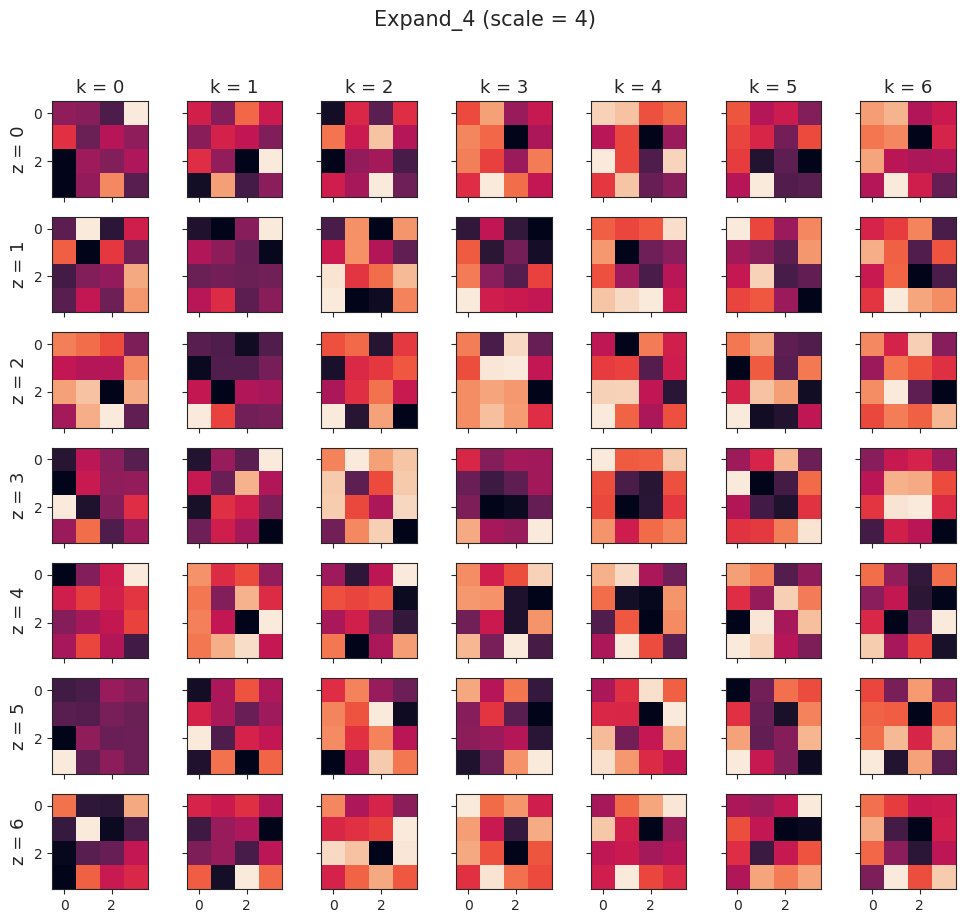

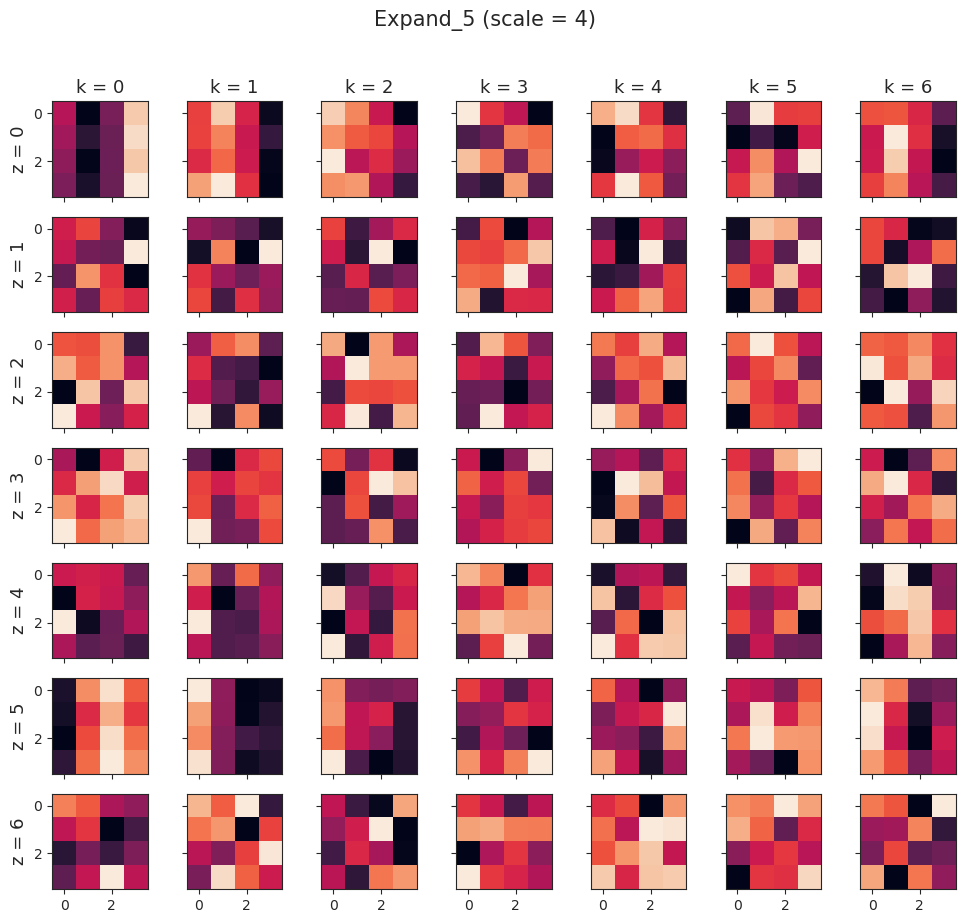

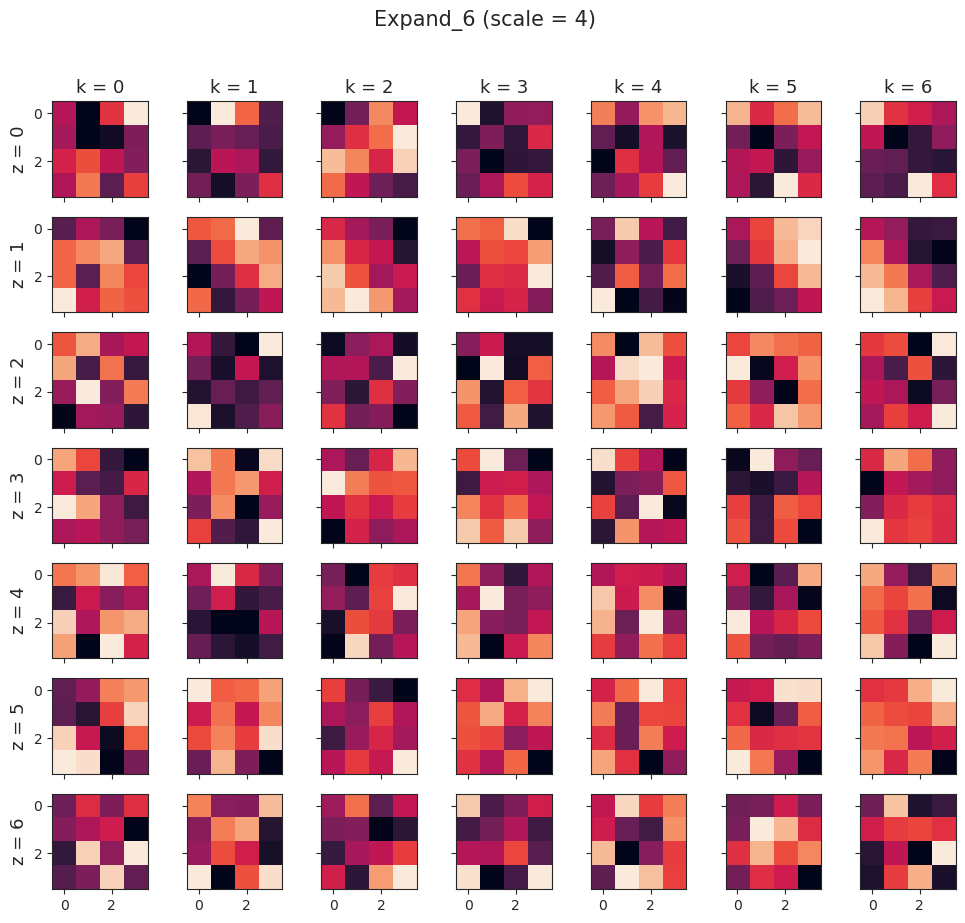

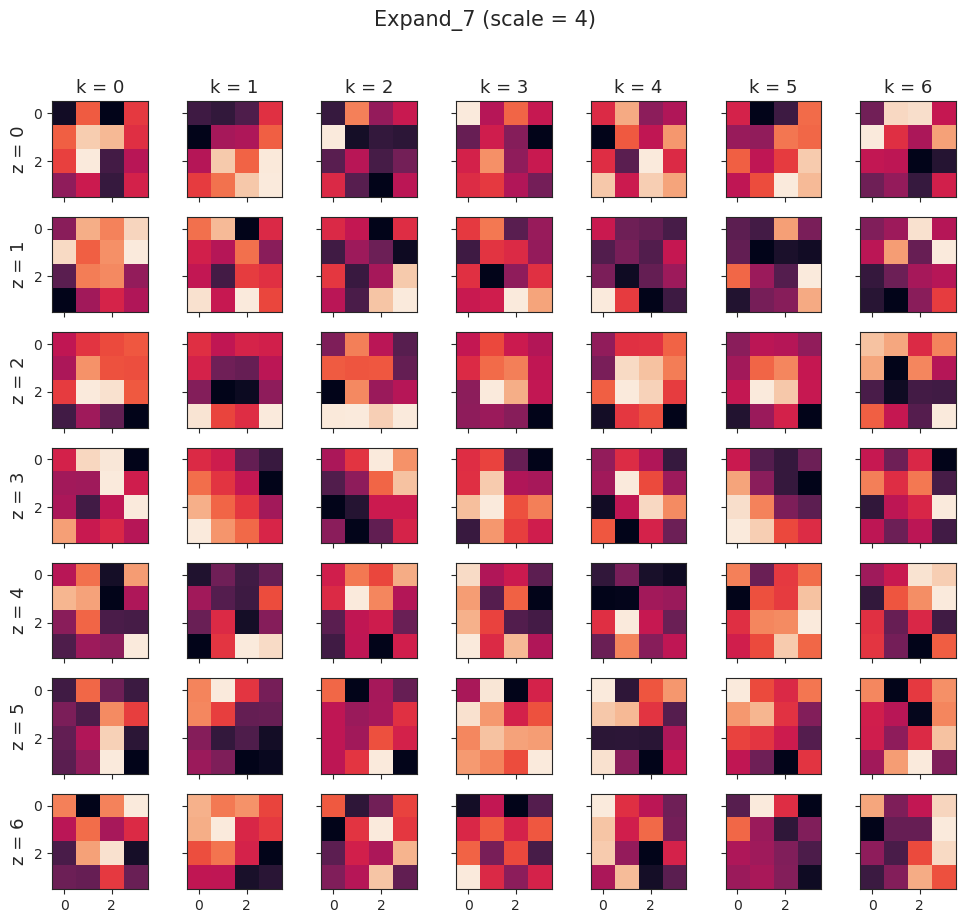

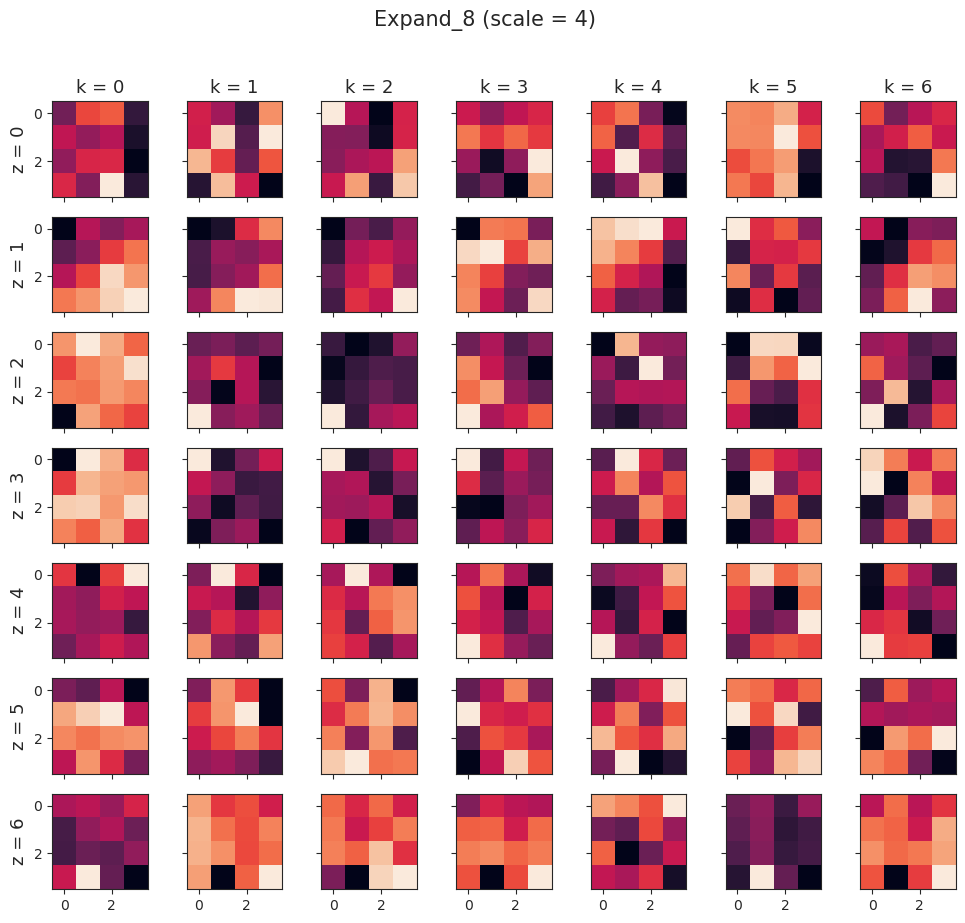

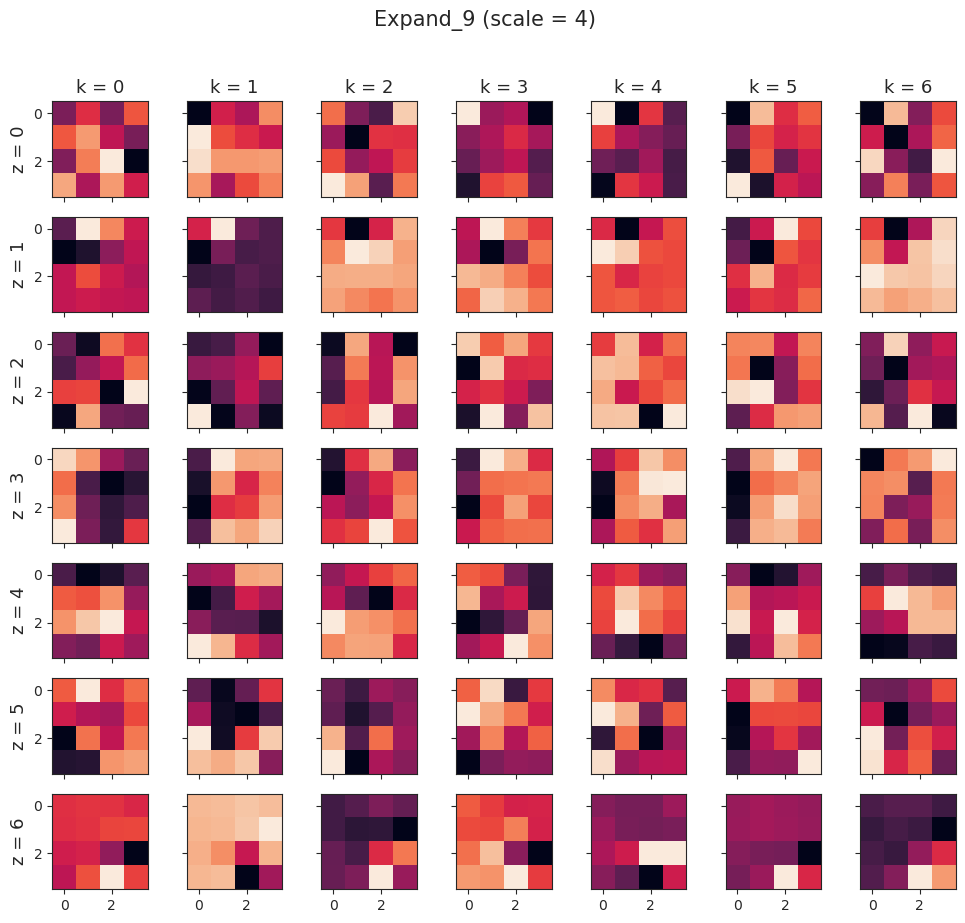

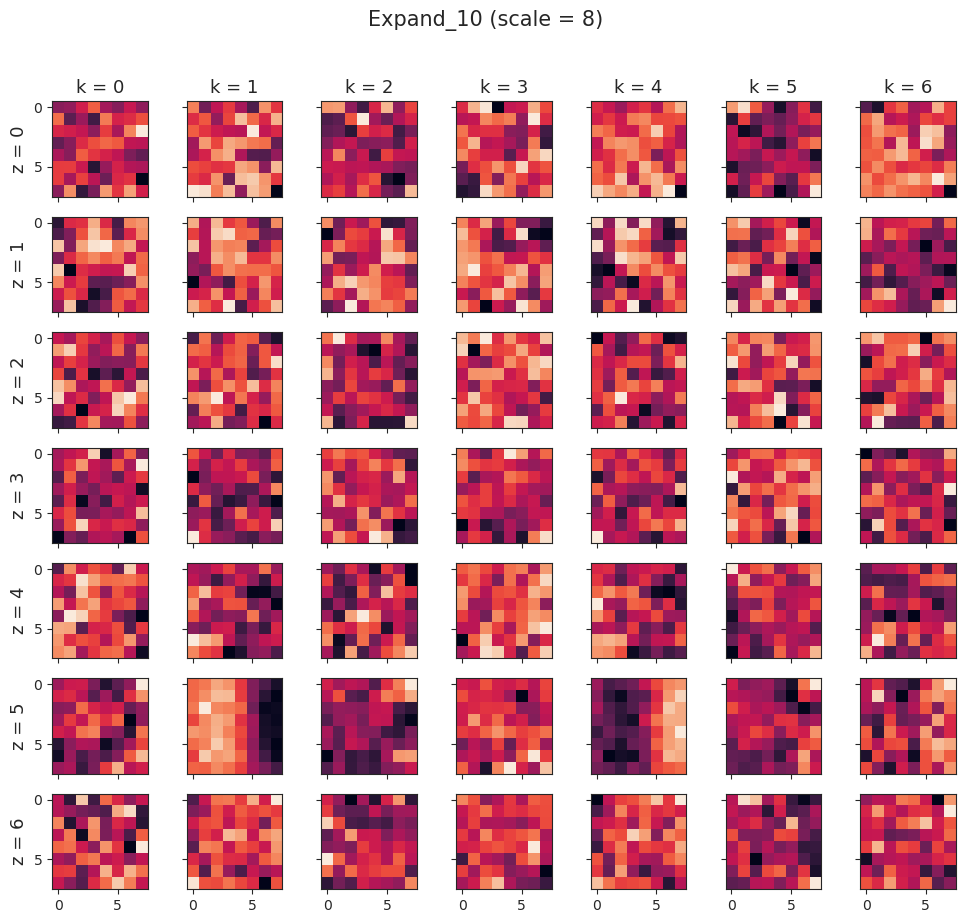

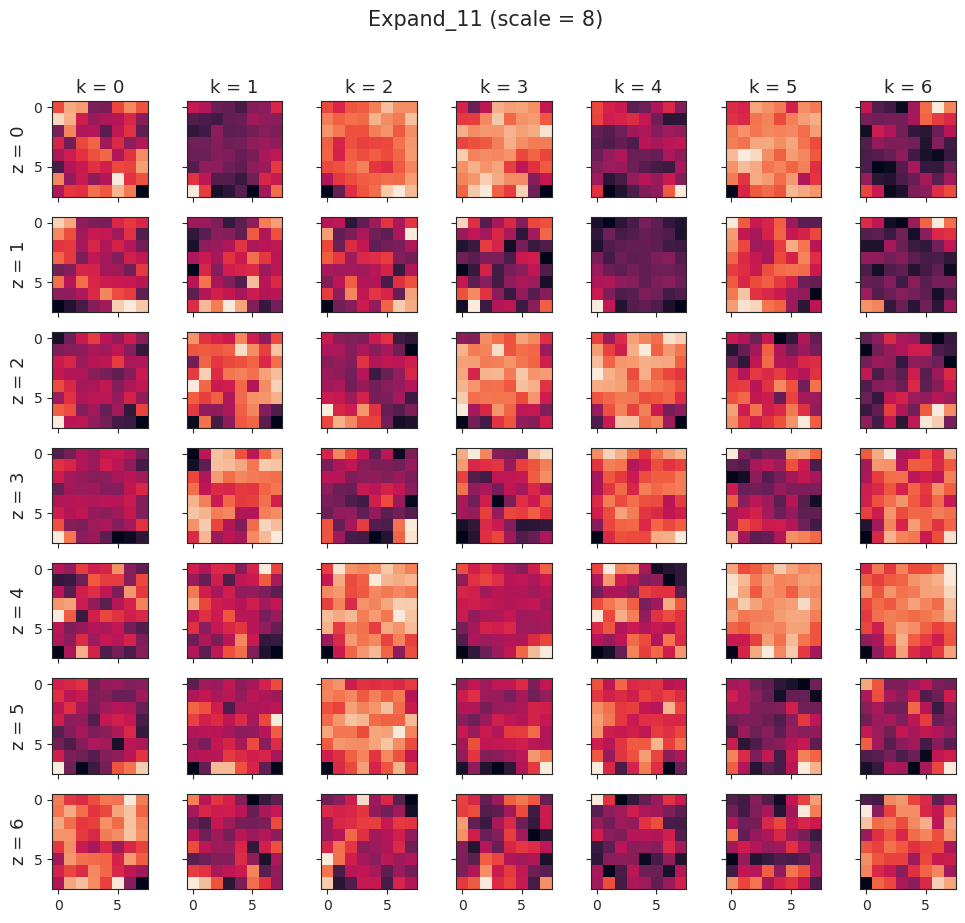

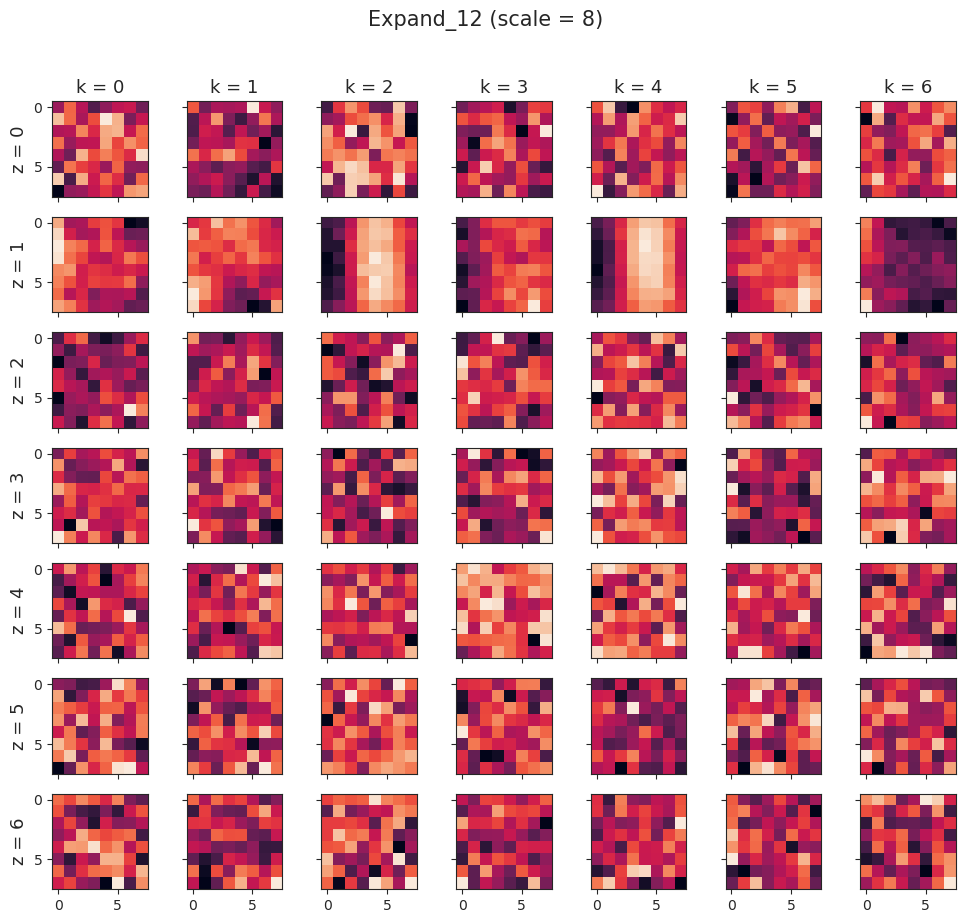

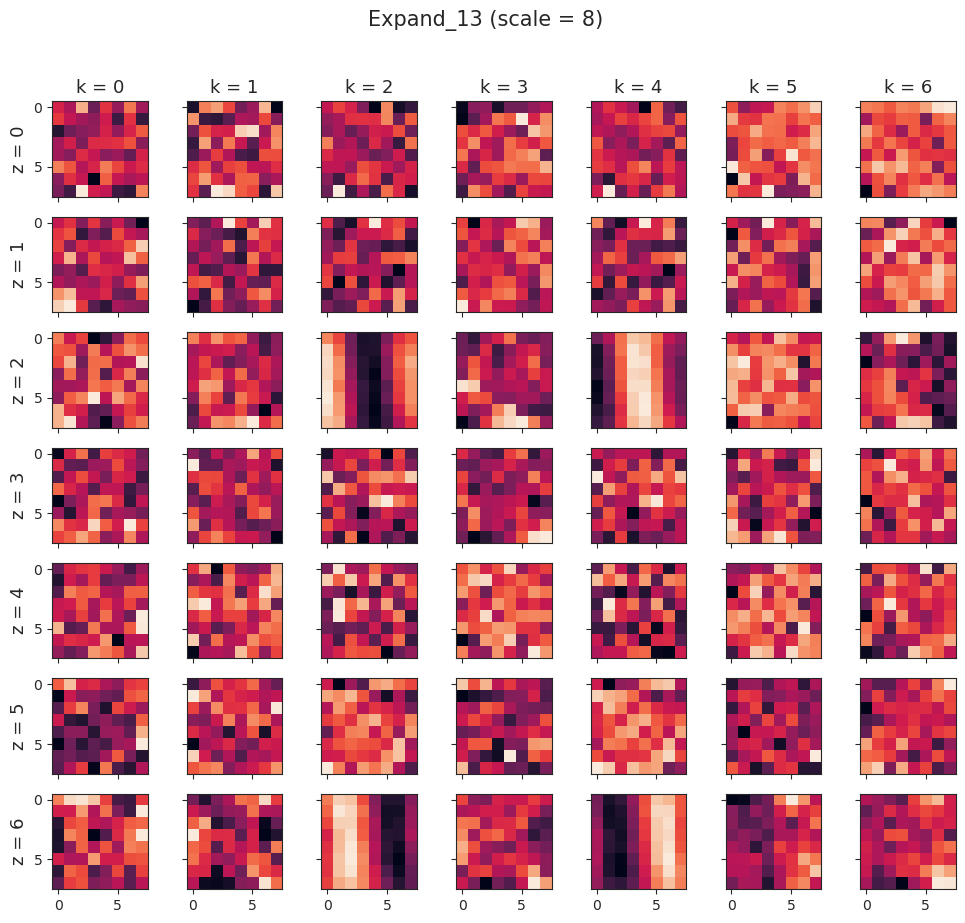

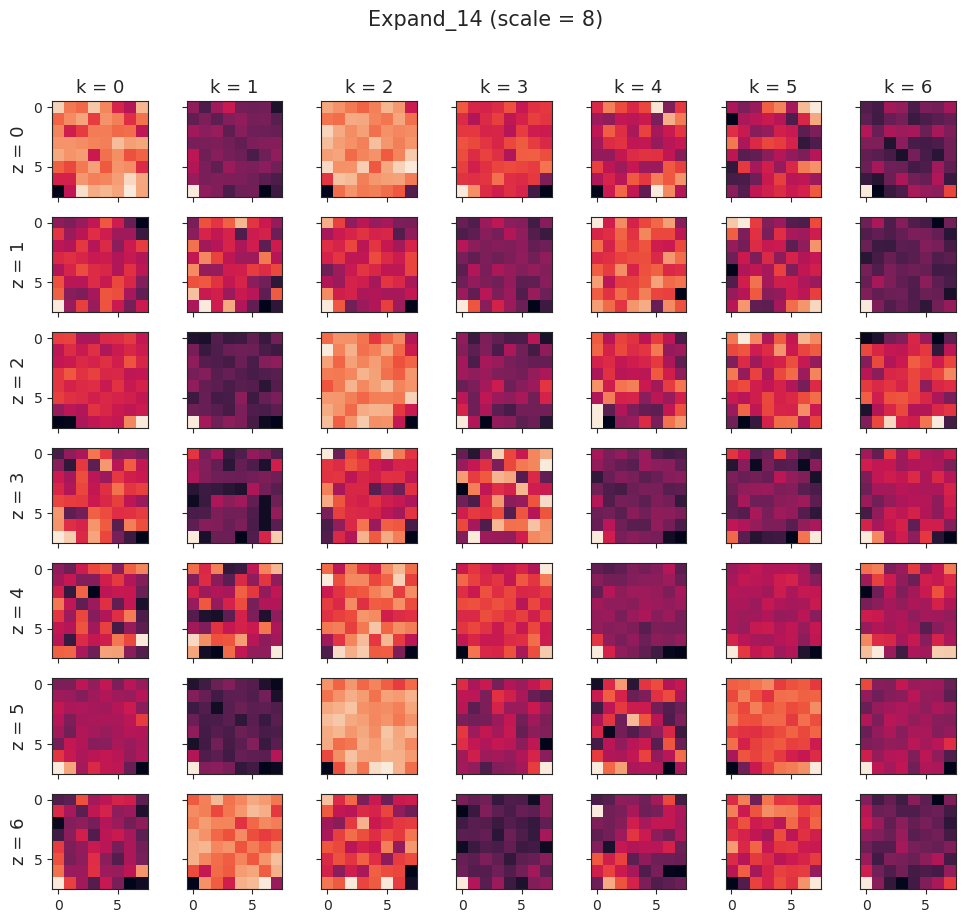

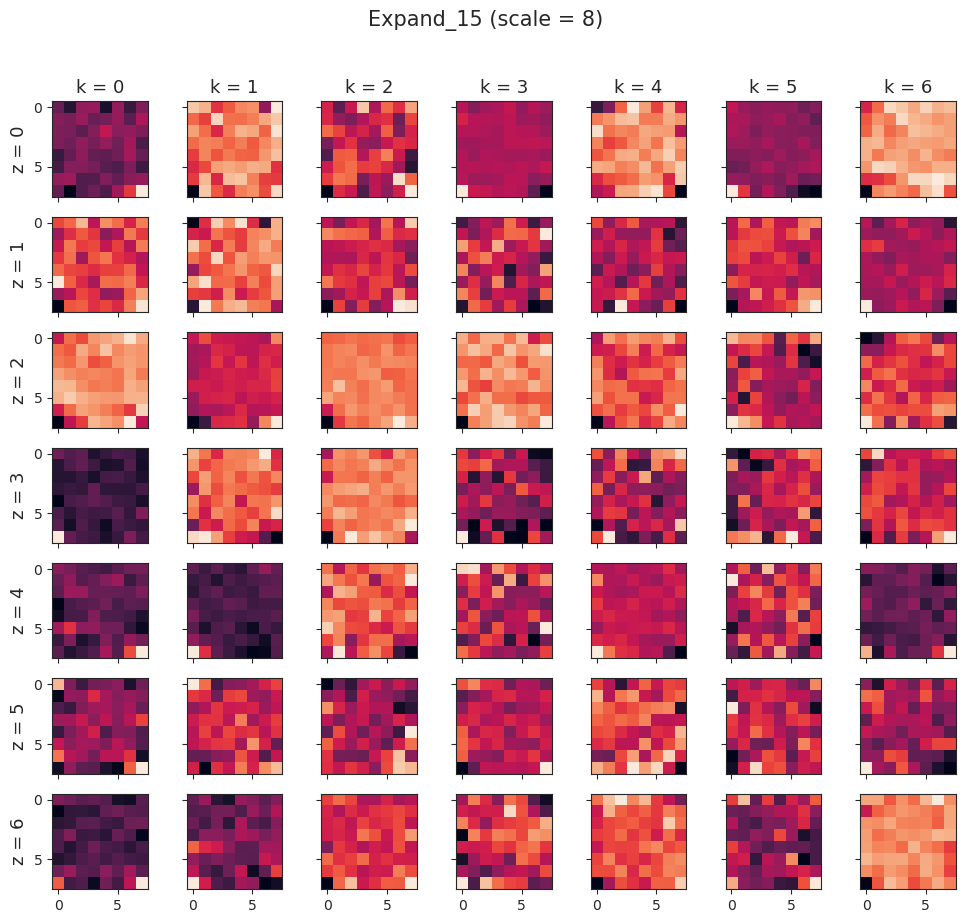

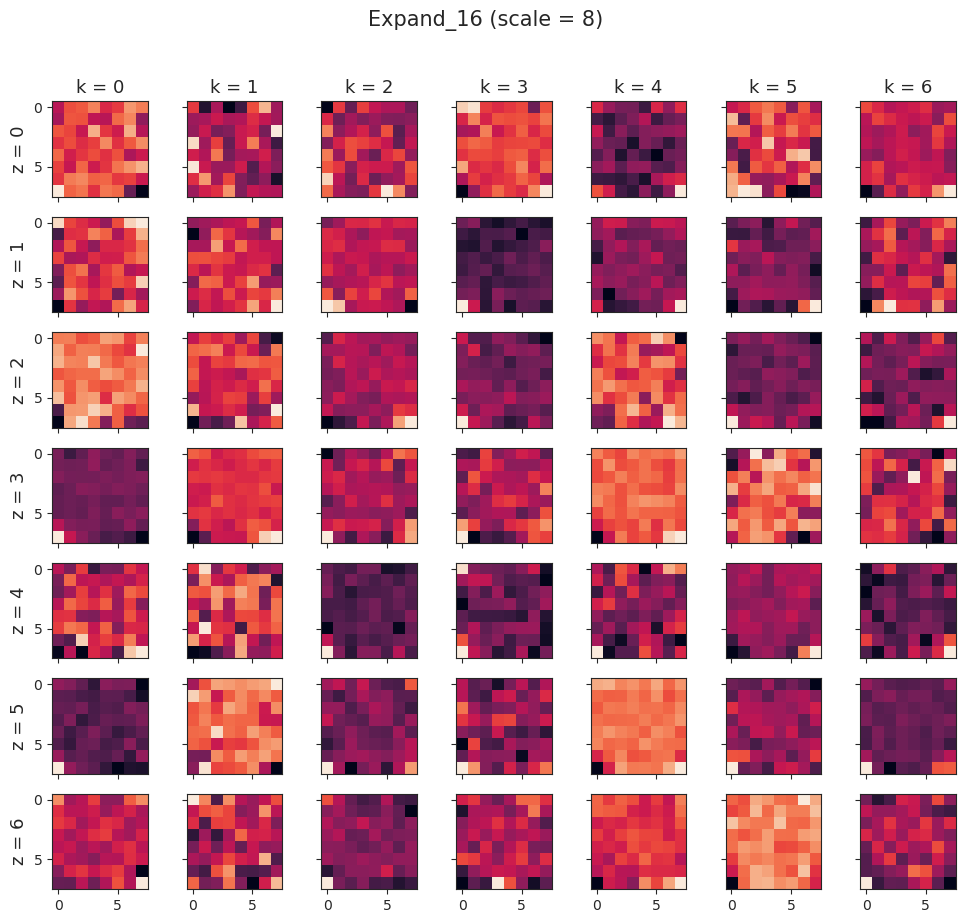

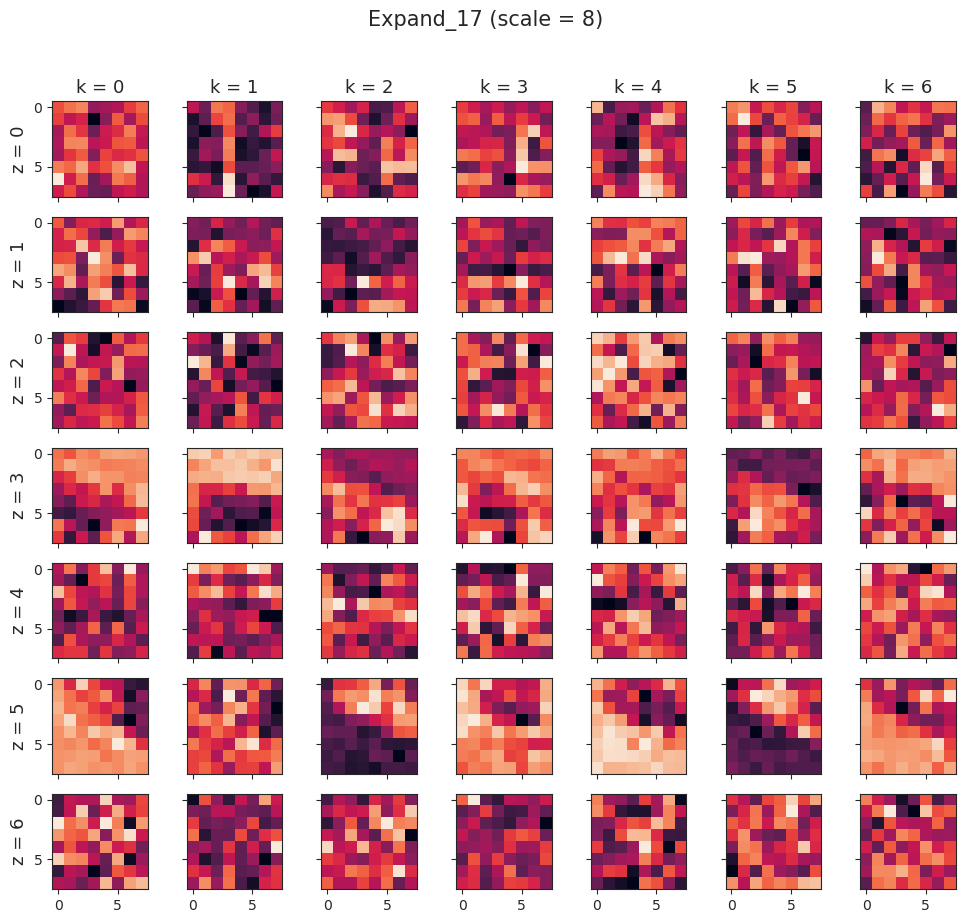

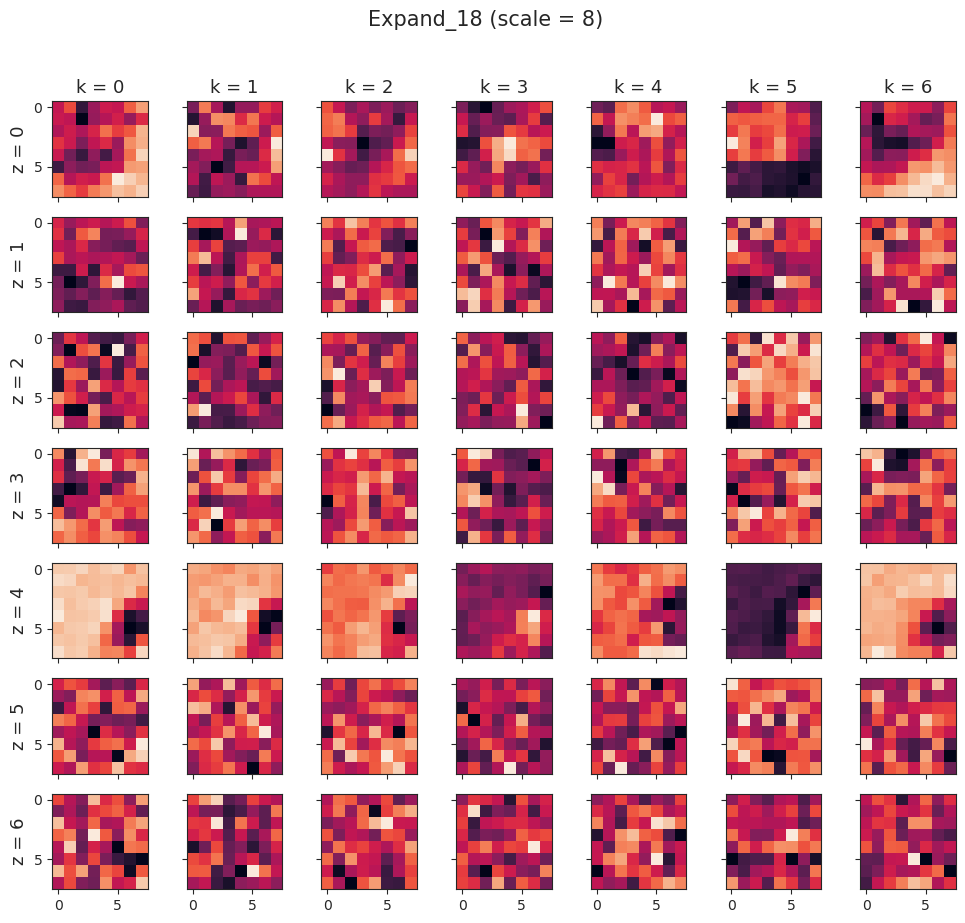

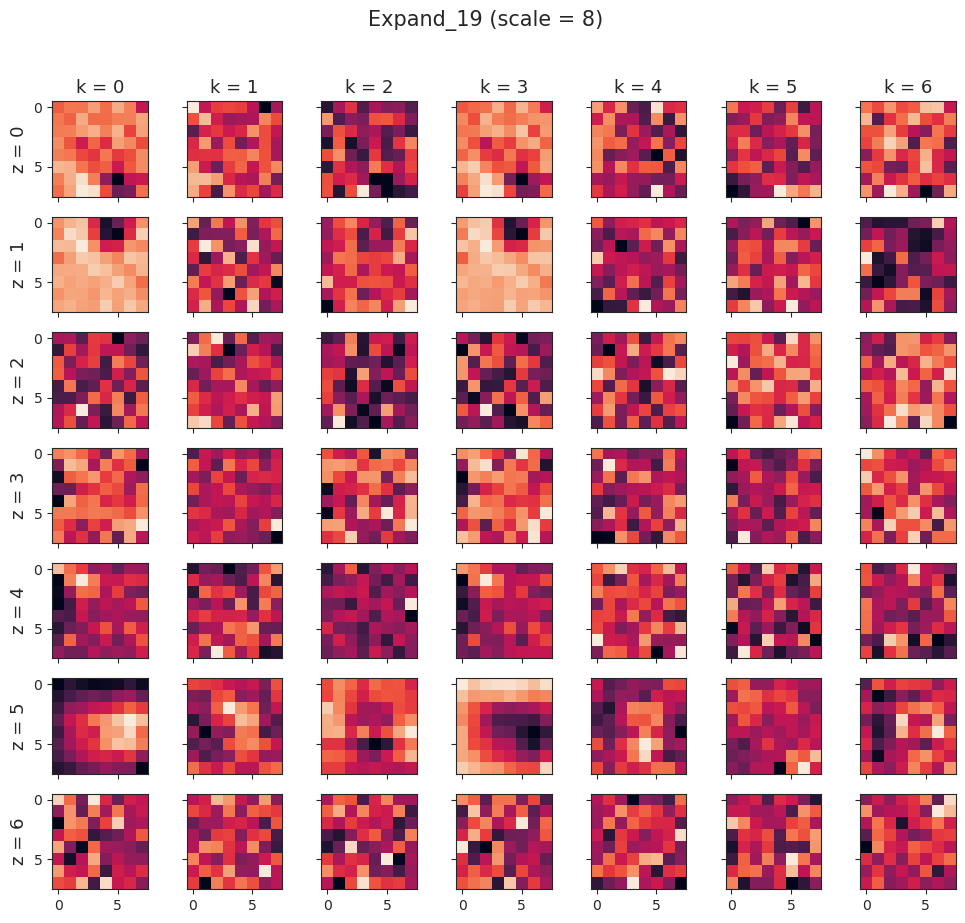

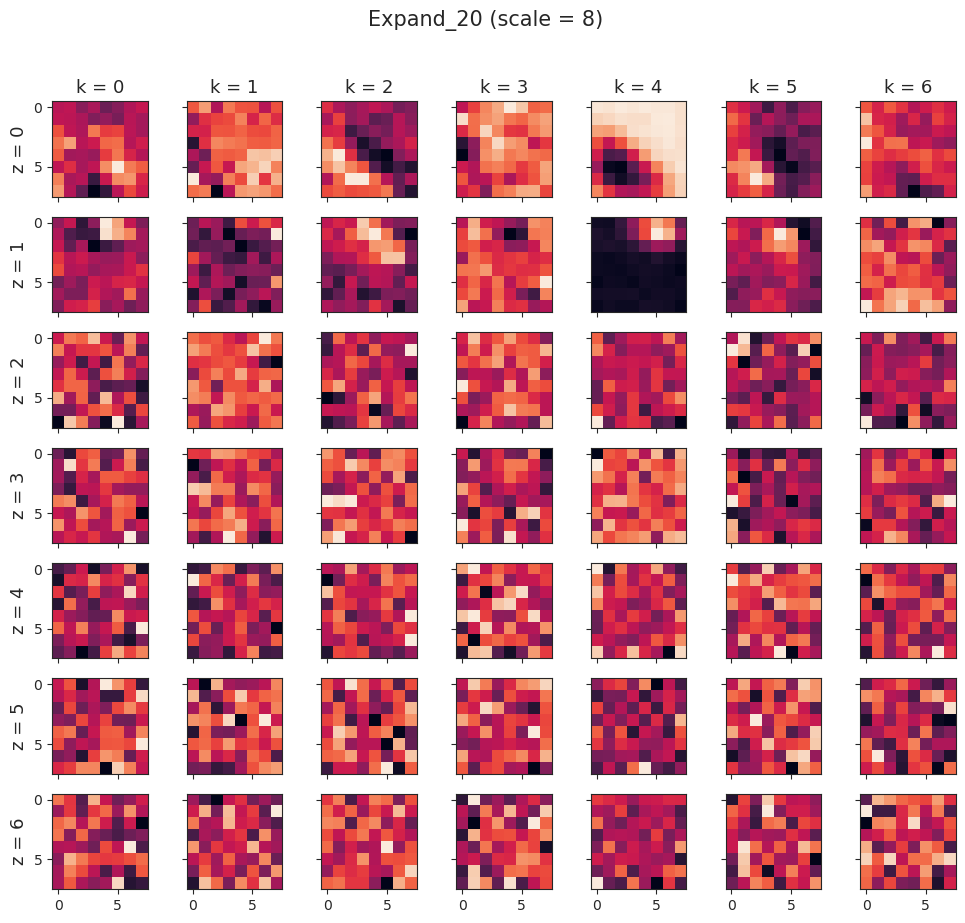

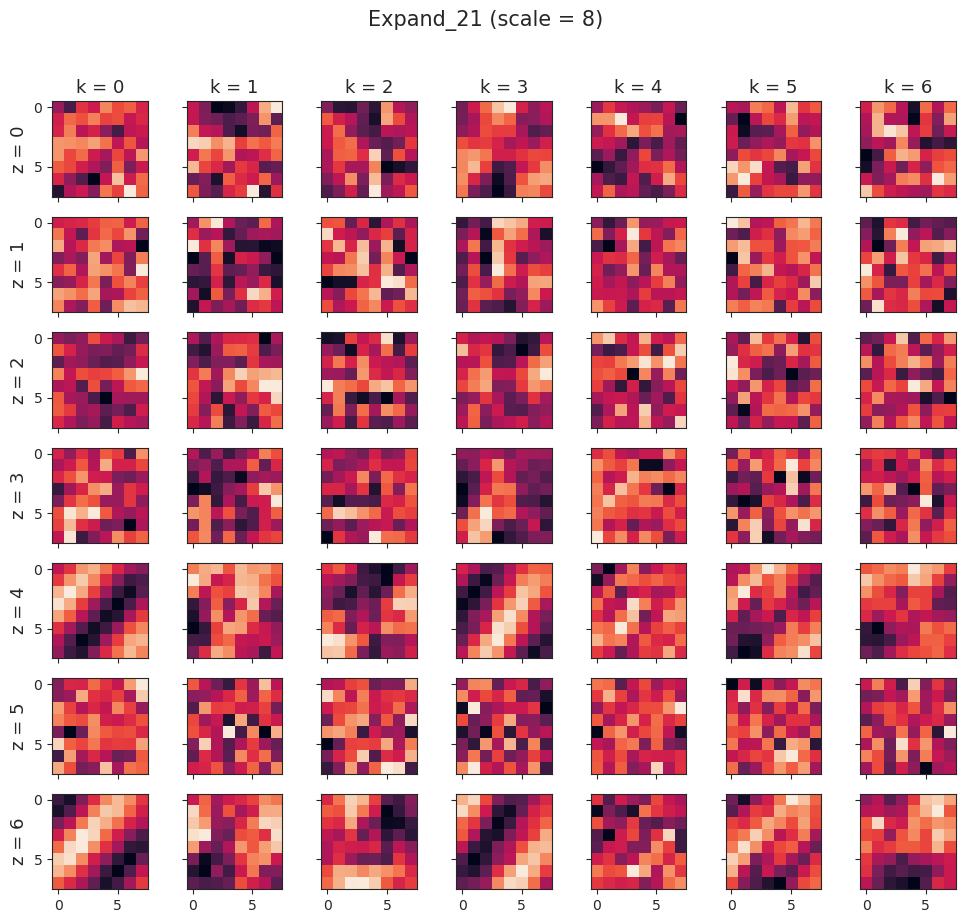

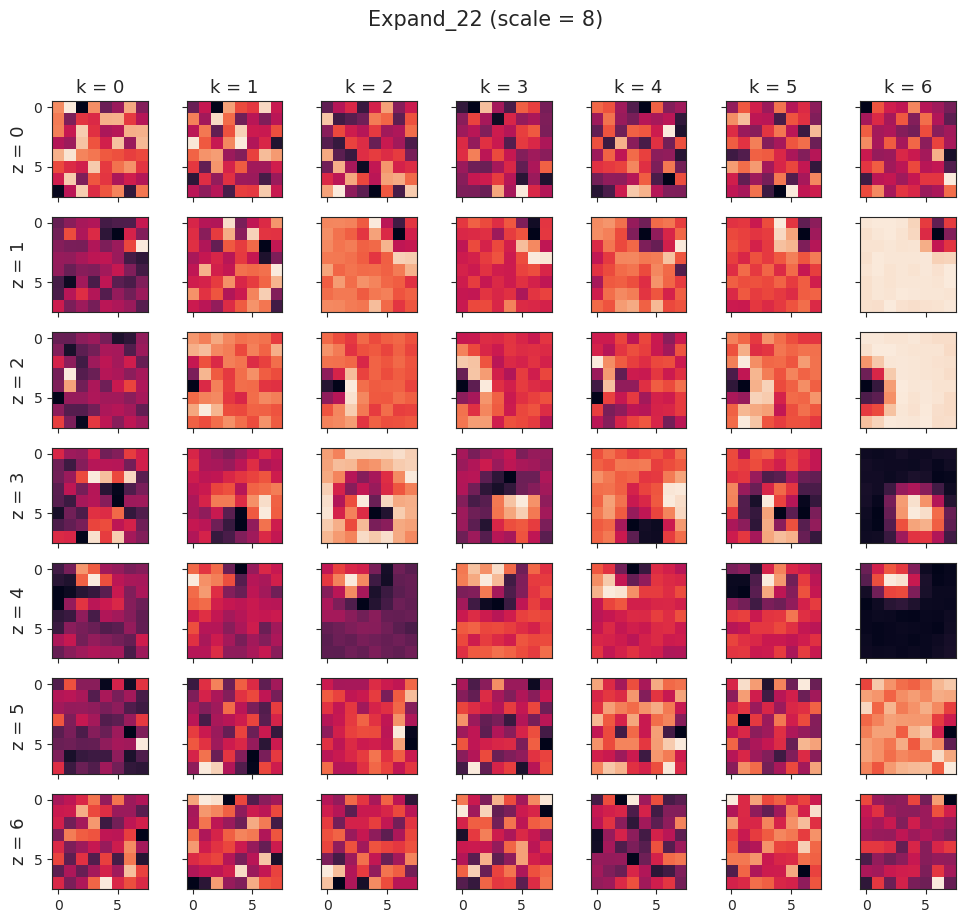

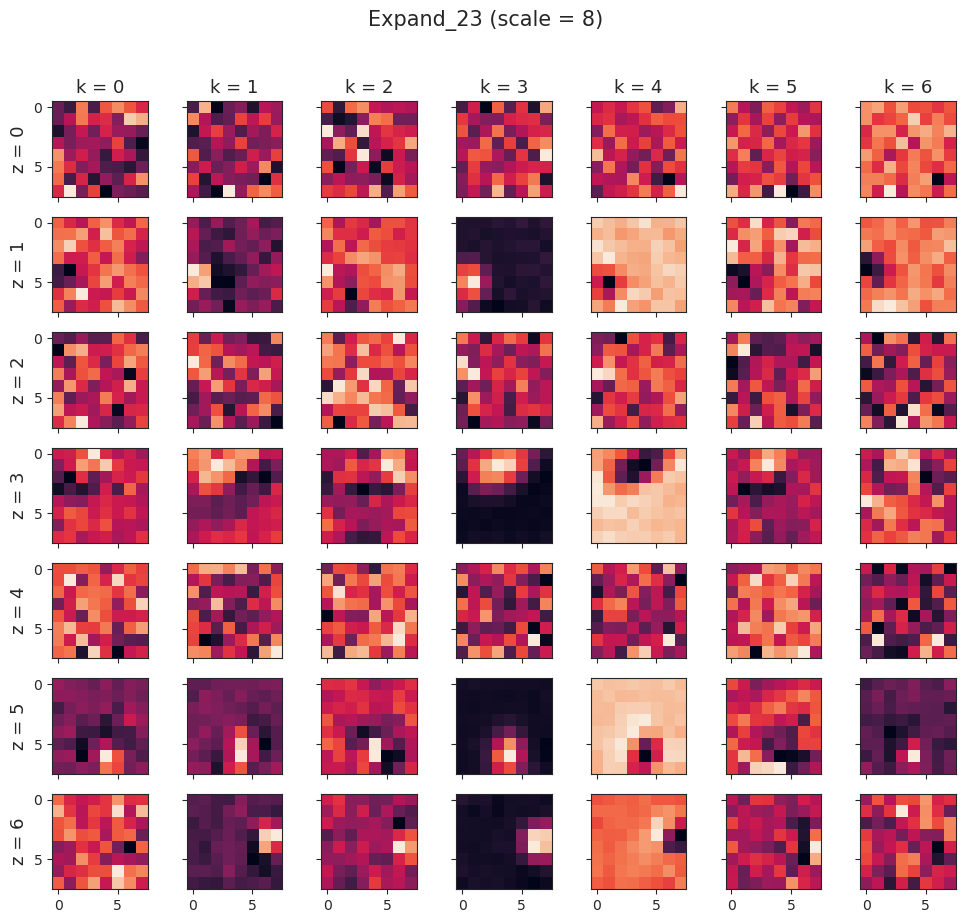

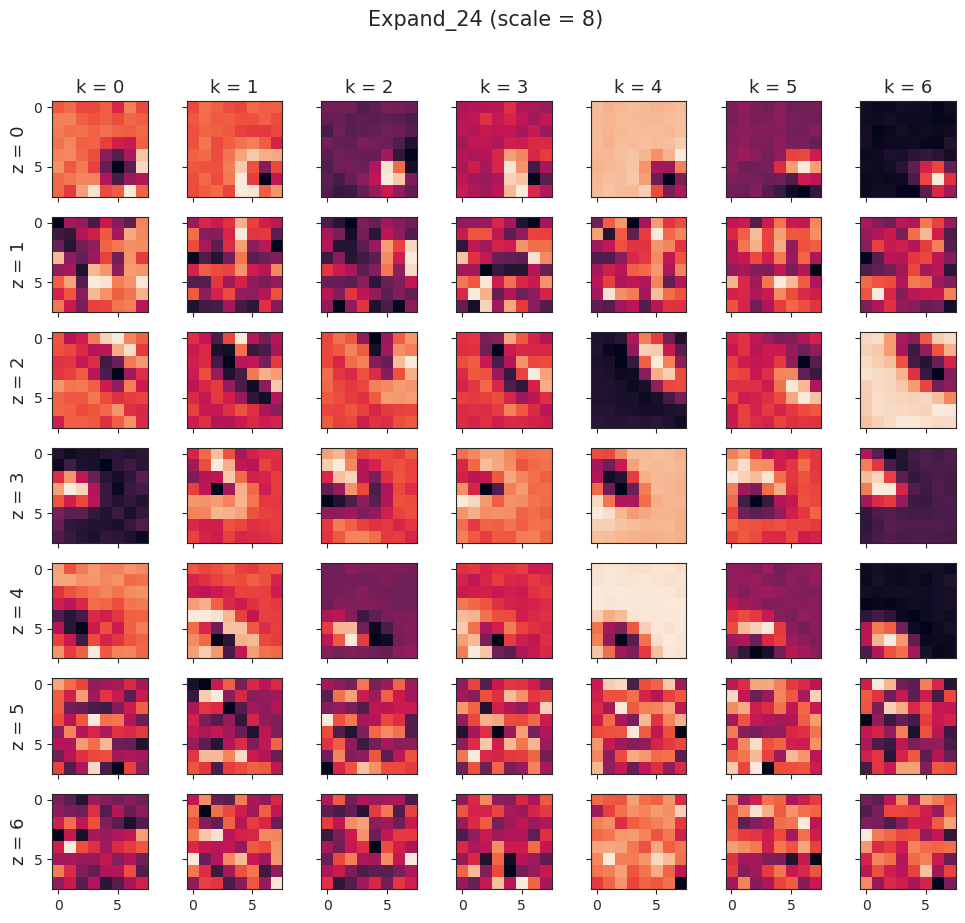

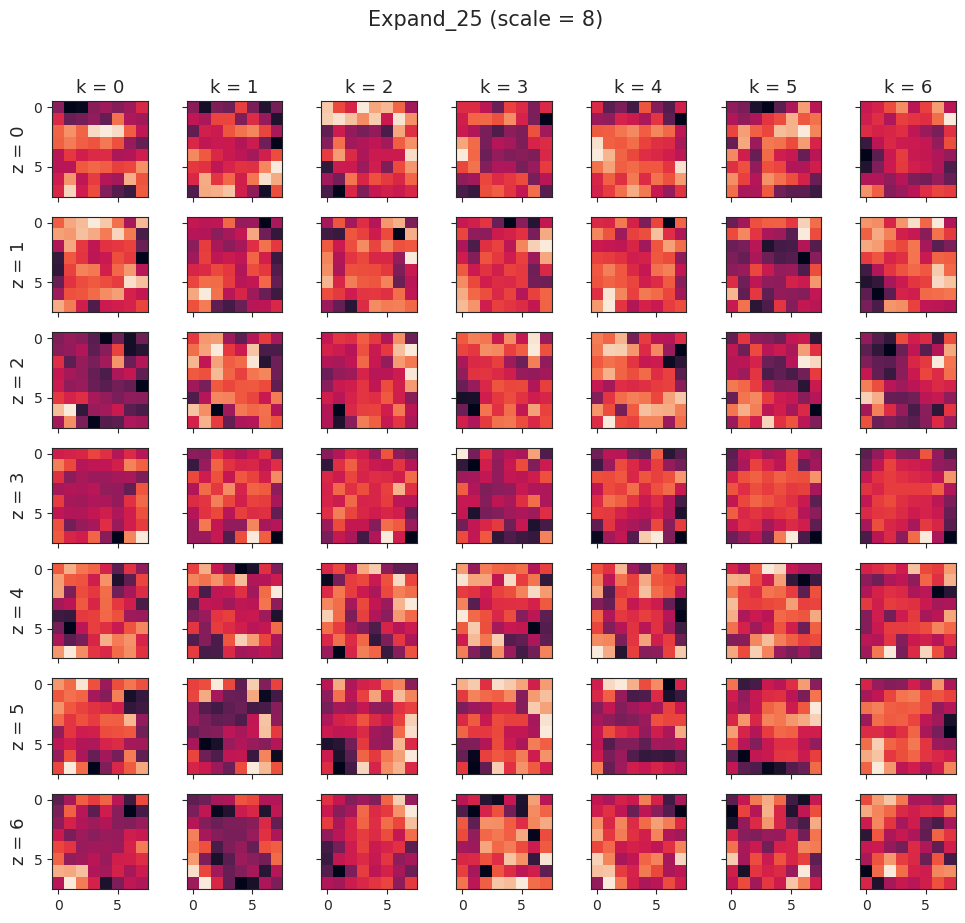

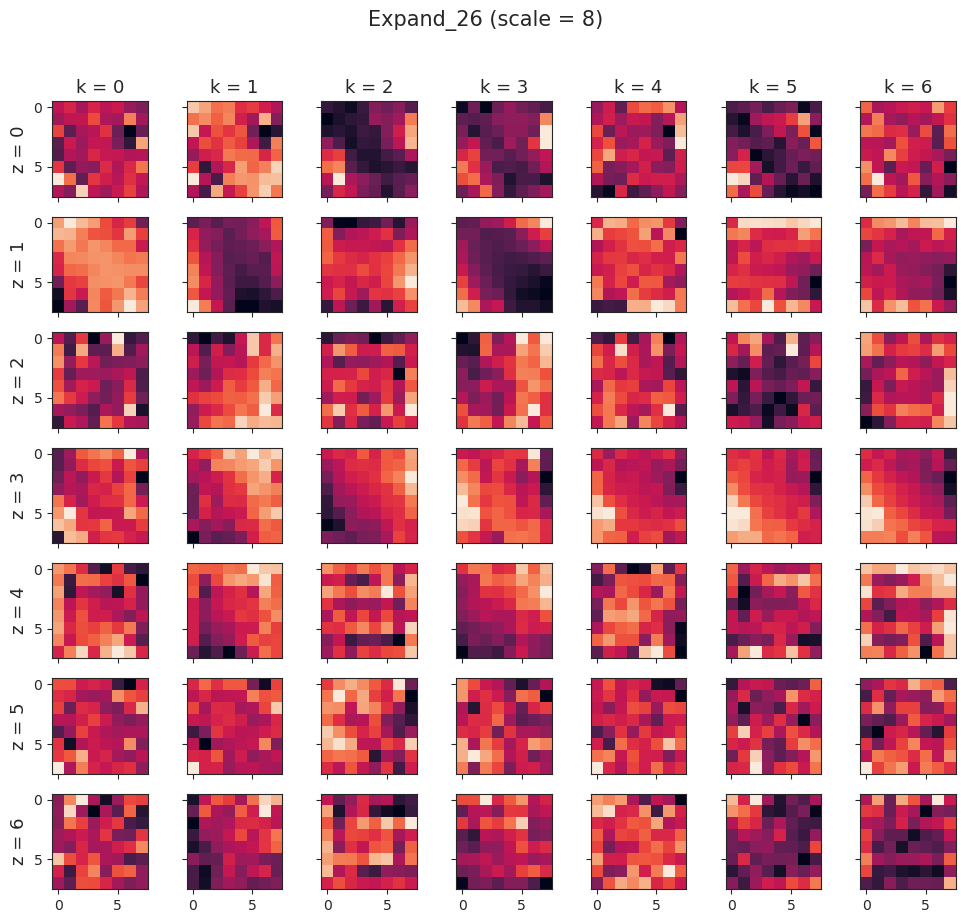

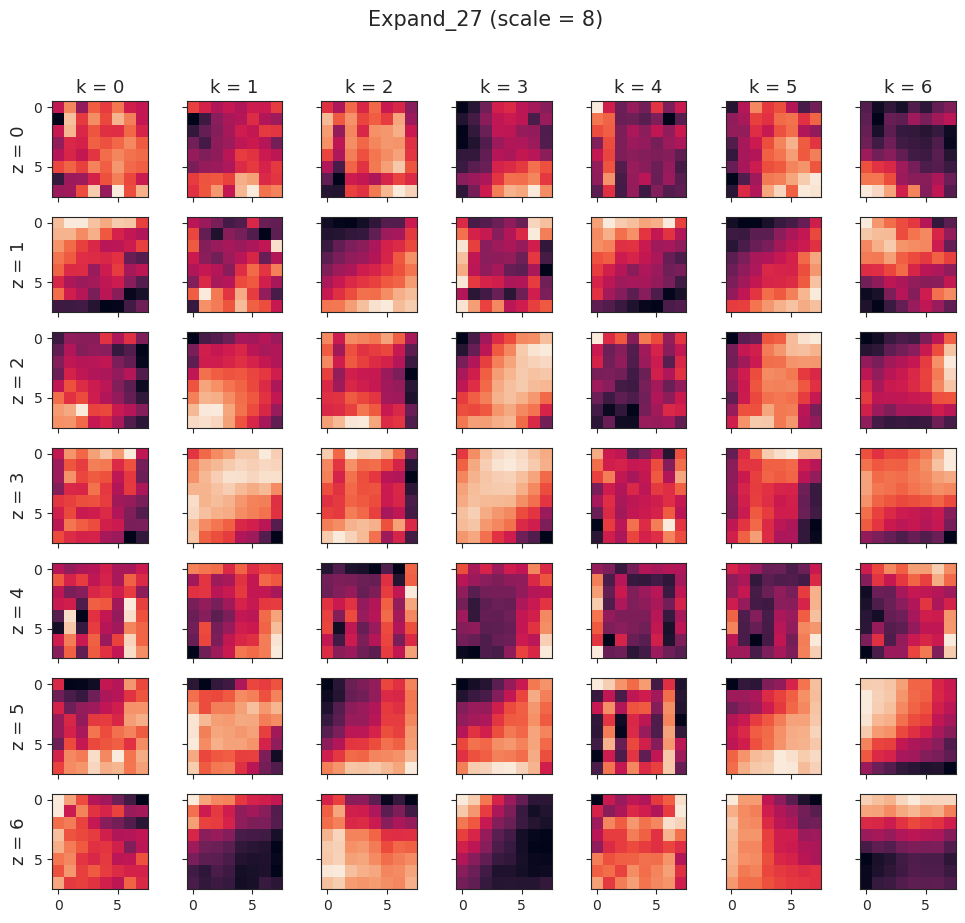

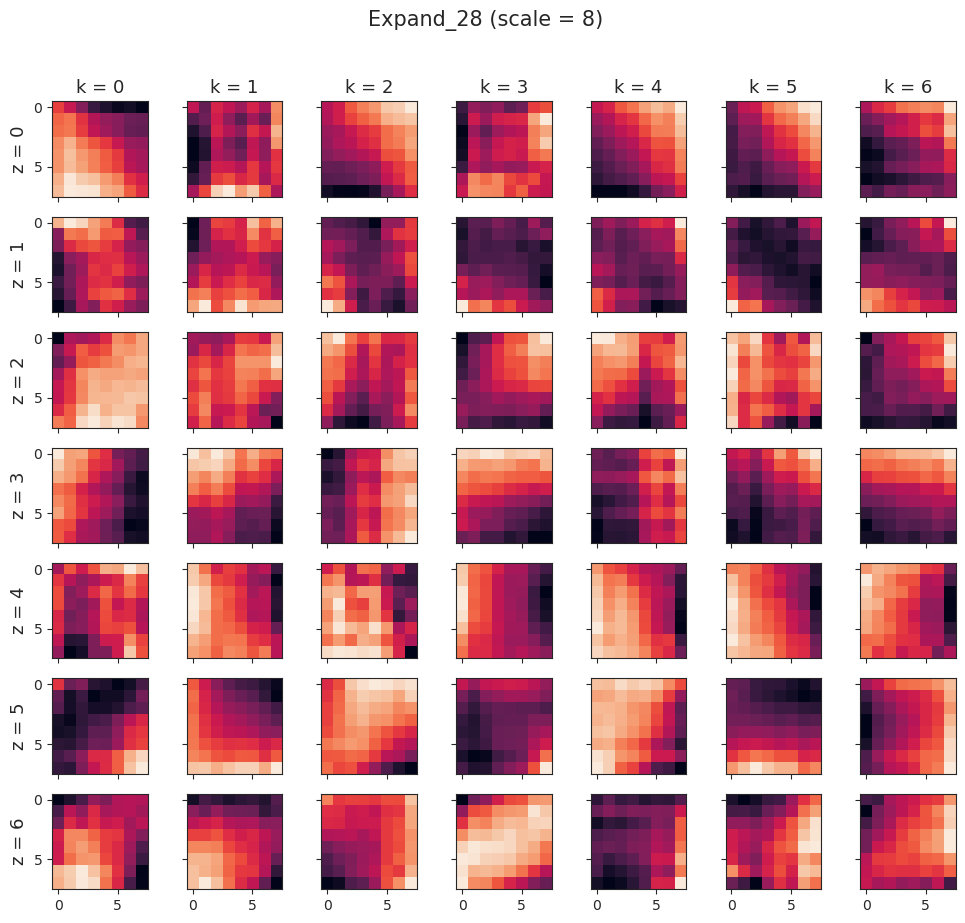

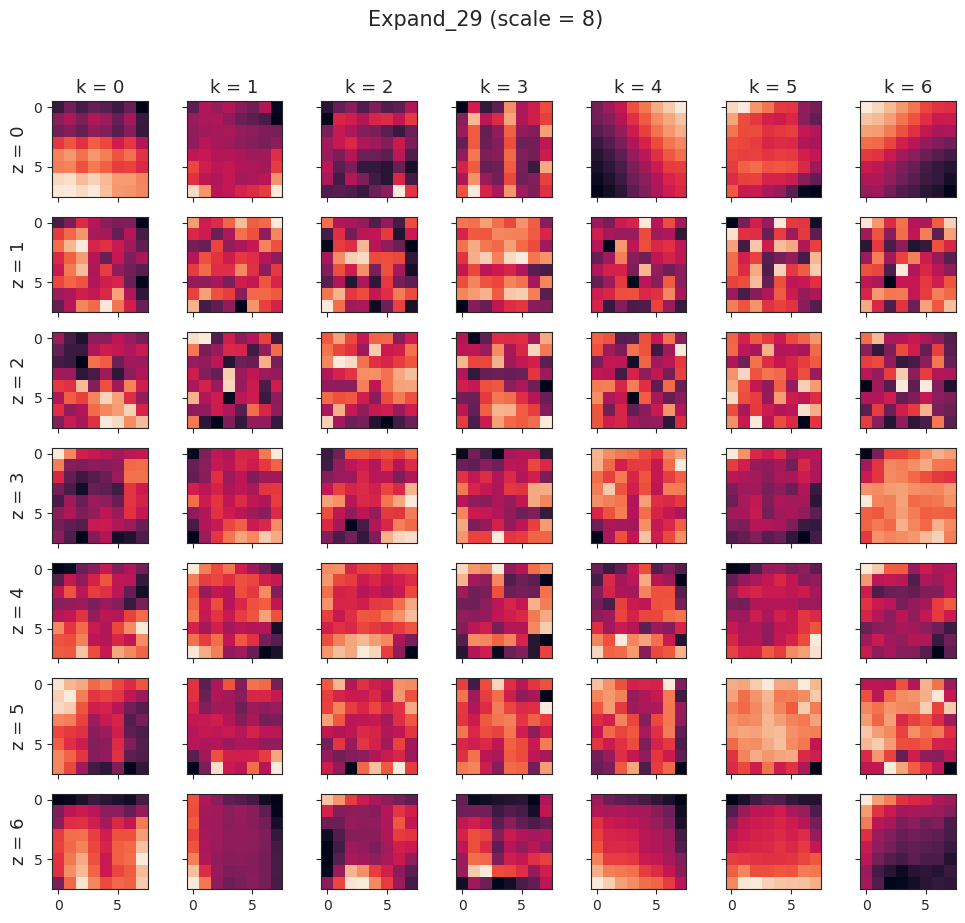

In [133]:
scales, _ = tr.model.latent_scales()
num = tr.model.cfg.n_latent_per_group

for i, m in enumerate(vae.expand):
    fig, axes = create_figure(num, num, (10, 9), 'all', 'all', tight_layout=True)
    for z, k in itertools.product(range(num), range(num)):
        ax = axes[z, k]
        ax.imshow(to_np(m.weight[z, k]))
        if z == 0:
            ax.set_title(f"k = {k}", fontsize=13)
        if k == 0:
            ax.set_ylabel(f"z = {z}", fontsize=13)
    fig.suptitle(f'Expand_{i} (scale = {scales[i]})', fontsize=15, y=1.02)
    plt.show()